In [53]:
import awkward as ak
import pathlib
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, MultipleLocator, ScalarFormatter, AutoMinorLocator
from scipy.optimize import curve_fit
from scipy import stats
import atlas_mpl_style as ampl
ampl.use_atlas_style()
#from codes.plotting import plot_prettier 
#plot_prettier()

In [54]:
bib_0_50 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\v0_BIB_0_50.json"))
bib_50_250 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\v0_BIB_50_250.json"))
bib_250_1000 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\v0_BIB_250_1000.json"))
pt_0_50 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\v0_noBIB_0-50.json"))
pt_50_250 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\v0_noBIB_50-250.json"))
pt_250_1000_dr = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\v0_noBIB_250-1000_dr_0.1.json"))
pt_250_1000 = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\v0_noBIB_250-1000.json"))
merged = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\v0_noBIB_merged.json"))
legacy = ak.from_json(pathlib.Path(r"C:\Users\leoro\OneDrive\Muon_Collider\Psets\mucol_plotting_scripts-main\macros\local_scripts\makeMuonPlots.json"))

In [55]:
mcp_pt = merged['mcp_pt']
mcp_eta = merged['mcp_eta']
mcp_phi = merged['mcp_phi'] 
mcp_mu_pt = merged['mcp_mu_pt']
mcp_mu_eta = merged['mcp_mu_eta']
mcp_mu_phi = merged['mcp_mu_phi']
# pfo_pt = merged['pfo_pt']
# pfo_eta = merged['pfo_eta']
# pfo_phi = merged['pfo_phi']
# pfo_mu_pt = merged['pfo_mu_pt']
# pfo_mu_eta = merged['pfo_mu_eta']
# pfo_mu_phi = merged['pfo_mu_phi']
# # mcp_mu_match_pt = merged['mcp_mu_match_pt']
# mcp_mu_match_eta = merged['mcp_mu_match_eta']
# mcp_mu_match_phi = merged['mcp_mu_match_phi']
# d_mu_dpt = merged['d_mu_dpt']
# d_mu_drelpt = merged['d_mu_drelpt']
# d_mu_dphi = merged['d_mu_dphi']
# d_mu_deta = merged['d_mu_deta']
# pt_res_vs_eta = merged['pt_res_vs_eta']
# pt_res_vs_pt = merged['pt_res_vs_pt']
# d0_res_vs_pt = merged['d0_res_vs_pt']
# d0_res_vs_eta = merged['d0_res_vs_eta']
# z0_res_vs_pt = merged['z0_res_vs_pt']
# z0_res_vs_eta = merged['z0_res_vs_eta']
# h2d_relpt = merged['h_2d_relpt']
nhits = merged['nhits']
pixel_nhits = merged['pixel_nhits']
pt_res_hits = merged['pt_res_hits']
d0_res = merged['d0_res']
z0_res = merged['z0_res']
track_pt = merged['track_pt']
pt_res = merged['pt_res'] 
pt_match = merged['pt_match'] #THIS IS TRUTH PT
eta_match = merged['eta_match'] #Truth eta
track_eta = merged['track_eta'] #Track eta
theta_match = merged['theta_match']
phi_match = merged['phi_match'] #Track phi
d0_res_match = merged['d0_res_match']
z0_res_match = merged['z0_res_match']
ndf = merged['ndf']
chi2 = merged['chi2']

LC_nhits = merged['LC_nhits']
LC_pixel_nhits = merged['LC_pixel_nhits']
LC_d0 = merged['LC_d0']
LC_z0 = merged['LC_z0']
LC_track_pt = merged['LC_track_pt']
LC_track_theta = merged['LC_track_theta']
LC_track_eta = merged['LC_track_eta']
LC_pt_res = merged['LC_pt_res']
LC_pt_match = merged['LC_pt_match']
LC_eta_match = merged['LC_eta_match']
LC_phi_match = merged['LC_phi_match']
LC_ndf = merged['LC_ndf']
LC_chi2 = merged['LC_chi2']

fake_pt = merged['fake_pt']
fake_theta = merged['fake_theta']
fake_eta = merged['fake_eta']
fake_phi = merged['fake_phi']
fake_d0 = merged ['fake_d0']
fake_z0 = merged['fake_z0']
fake_ndf = merged['fake_ndf']
fake_chi2 = merged['fake_chi2']
fake_nhits = merged['fake_nhits']
fake_pixel_nhits = merged ['fake_pixel_nhits']


In [56]:
# pt_res = ak.concatenate([pt_250_1000['pt_res'],pt_50_250['pt_res'],pt_0_50['pt_res']],axis=0) 
# pt_match = ak.concatenate([pt_250_1000['pt_match'],pt_50_250['pt_match'],pt_0_50['pt_match']],axis=0)
# eta_match = ak.concatenate([pt_250_1000['eta_match'],pt_50_250['eta_match'],pt_0_50['eta_match']],axis=0)
# ndf = ak.concatenate([pt_250_1000['ndf'],pt_50_250['ndf'],pt_0_50['ndf']],axis=0)
# chi2 = ak.concatenate([pt_250_1000['chi2'],pt_50_250['chi2'],pt_0_50['chi2']],axis=0)
# d0_res_match = ak.concatenate([pt_250_1000['d0_res_match'],pt_50_250['d0_res_match'],pt_0_50['d0_res_match']],axis=0)
# z0_res_match = ak.concatenate([pt_250_1000['z0_res_match'],pt_50_250['z0_res_match'],pt_0_50['z0_res_match']],axis=0)
print((len(pt_250_1000['pt_res'][(np.abs(np.ravel(pt_250_1000['pt_res']))<1)])/len((pt_250_1000['pt_res']))))
print(len(merged['LC_pt_match'])/len(merged['mcp_mu_pt']))
#print(len(bib_track_pt)/len(bib_truth_pt))

0.9575952764358562
0.8979171670727104


In [57]:
theta_match = 2 * np.arctan(np.exp(-eta_match))
print(eta_match)
print(theta_match)
theta_match = np.degrees(theta_match)
print(theta_match)

LC_theta_match = np.degrees(2 * np.arctan(np.exp(-LC_eta_match)))

theta_0_50 = np.degrees(2*np.arctan(np.exp(-pt_0_50['eta_match'])))
print(theta_0_50)
theta_50_250 = np.degrees(2*np.arctan(np.exp(-pt_50_250['eta_match'])))
print(theta_50_250)
theta_250_1000 = np.degrees(2*np.arctan(np.exp(-pt_250_1000['eta_match'])))
print(theta_250_1000)

bib_0_50_theta = np.degrees(2*np.arctan(np.exp(-bib_0_50['LC_eta_match'])))
bib_50_250_theta = np.degrees(2*np.arctan(np.exp(-bib_50_250['LC_eta_match'])))
bib_250_1000_theta = np.degrees(2*np.arctan(np.exp(-bib_250_1000['LC_eta_match'])))


[[-0.0074], [-0.594], [0.648], [1.86], ..., [1.46], [0.811], [0.231], [0.604]]
[[1.58], [2.13], [0.964], [0.308], [2.66], ..., [0.457], [0.836], [1.34], [1]]
[[90.4], [122], [55.2], [17.7], [152], ..., [26.2], [47.9], [76.9], [57.3]]
[[148], [131], [93.1], [82.4], [89.3], ..., [150], [134], [129], [27.3], [100]]
[[70.7], [110], [54.4], [164], [86.8], ..., [91.2], [46], [159], [57.3], [151]]
[[63.3], [86.7], [92.1], [94.2], [146], ..., [113], [99.1], [127], [79.9]]


### Binning impact parameters by $p_T$ (NB: this code is for legacy data)

In [58]:
pT_ranges = [0,50, 250, 1000]  # The last value should be np.inf to cover 200+ GeV

# Define relaxed cutoffs for lower pT ranges
pT_d0_cutoffs = [0.8, 0.7, 0.6, 0.5]  
pT_z0_cutoffs = [1.8, 1.7, 1.6, 1.5]  

# Initialize the target arrays with NaN values to preserve the dtype
d0_masked = []
z0_masked = []
LC_pt_res_masked = []
pt_masked_d0 = []
pt_masked_z0 = []
theta_masked_d0 = []
theta_masked_z0 = []

# Create subsets of legacy for different pT ranges and apply resolution cutoffs
for i in range(len(pT_ranges) - 1):
    pT_min = pT_ranges[i]
    pT_max = pT_ranges[i + 1]

    # Create a mask for the current pT range
    mask = np.array([pT_min <= x[0] < pT_max for x in LC_pt_match])  

    # Apply resolution cutoffs for d0 and z0
    d0_cutoff = np.array([x[0] < pT_d0_cutoffs[i] for x in LC_d0])
    z0_cutoff = np.array([x[0] < pT_z0_cutoffs[i] for x in LC_z0])
    theta_cutoff = np.array([70 <= x[0] < 110 for x in LC_theta_match])
    d0_mask = mask & theta_cutoff
    z0_mask = mask & theta_cutoff
    # Create subsets of legacy for the current pT range and apply the resolution cutoffs
    #pT_subset = LC_pt_match[mask]
    d0_masked.append(LC_d0[d0_mask])
    z0_masked.append(LC_z0[z0_mask])
    dpT_pt = []
    for x, y in zip(LC_pt_res[d0_mask], LC_pt_match[d0_mask]):
        dpT_pt.append([x[0] / y[0]])
    LC_pt_res_masked.append(dpT_pt)  
    pt_masked_d0.append(LC_pt_match[d0_mask])
    pt_masked_z0.append(LC_pt_match[z0_mask])
    theta_masked_d0.append(LC_theta_match[d0_mask])
    theta_masked_z0.append(LC_theta_match[z0_mask])
    print('# of points in pT range', pT_min, '-', pT_max, '=', len(LC_theta_match[d0_mask]))
print(LC_pt_res_masked)
print(theta_masked_d0)
# print(len(d0_masked))
# print(len(theta_masked_d0))
# for i in range(len(d0_masked)):
#     print(len(d0_masked[i]))
#     print(len(theta_masked_d0[i]))

# of points in pT range 0 - 50 = 2354
# of points in pT range 50 - 250 = 2406
# of points in pT range 250 - 1000 = 2215
[[[-1.1577728580319429e-05], [-1.5398234417949798e-05], [5.1046813072137916e-05], [0.000842441321103318], [0.0001448518362107316], [-0.0006454374396724542], [-9.783313188973498e-05], [2.2131907580783306e-06], [0.00012107464158187527], [0.007789740177123972], [-3.321173263120603e-05], [0.00020101827613759032], [-6.459836457812228e-05], [-6.428690361574587e-05], [-8.253333496767895e-05], [-4.195090517039595e-05], [8.44854235013412e-06], [-0.05709338038436368], [-0.07431893155382704], [-6.180542874973882e-05], [-1.9049419044717742e-05], [-7.121381148470322e-05], [-0.00011917278911396485], [-0.00016397226729738198], [-0.00012446976200095449], [8.766958719118141e-05], [-5.854725460003999e-05], [0.0009710119661737245], [-0.0027325015766057987], [7.38643736563607e-05], [-9.956162408174453e-05], [-0.3315444644318179], [-0.0001844877027655398], [-0.00010746692539790025], [-2.8

### Plotting Functions

In [115]:
# Function for creating a Gaussian fit
def gaussian(x, a, mu, sigma):
    return a * np.exp(-0.5 * ((x - mu) / sigma)**2)

def fit_gaussian(slice_data, bins = np.linspace(-0.5,0.5,300), mean = 0, rms = 0.01):
    """
    Fit a Gaussian to the input data slice.

    Parameters:
        slice_data (numpy.ndarray): Input data slice.
        bins (numpy.ndarray, optional): Binning for histogram. Default is np.linspace(-0.5, 0.5, 300).
        mean (float, optional): Mean value for the Gaussian fit. Default is 0.
        rms (float, optional): RMS value for the Gaussian fit. Default is 0.01.

    Returns:
        tuple: Tuple containing fit parameters (popt), covariance matrix (pcov), and bin centers.
    """
    if mean is None:
        mean = np.mean(slice_data)
    if rms is None:
        rms = np.sqrt(np.mean(np.square(slice_data - mean)))
    if bins is None:
        bins = np.linspace(-1,1, 300)
    counts, bin_edges = np.histogram(slice_data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=[max(counts), mean, rms])
    return popt, pcov, bin_centers

##############################################################################################################################################################################################################################
# Function for plotting RMS vs. eta/theta/pT for multiple pT bins

def plotrms_multi(datax, datay, bins, ylim = None, labels=['','',''], xlabel = '', ylabel='', title=''):
    """
    Plot RMS values against eta/theta/pT for multiple pT bins.

    Parameters:
        datax (list of numpy.ndarray): List of x-data arrays.
        datay (list of numpy.ndarray): List of y-data arrays.
        bins (int): Number of bins for the x-data histogram.
        ylim (tuple, optional): Y-axis limits. Default is None.
        labels (list of str, optional): Labels for the data series. Default is None.
        xlabel (str, optional): X-axis label. Default is an empty string.
        ylabel (str, optional): Y-axis label. Default is an empty string.
        title (str, optional): Plot title. Default is an empty string.
    """
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    for j in range(len(datay)):
        data_flatx = np.array(np.ravel(datax[j])).T
        data_flaty = np.array(np.ravel(datay[j])).T
        x_bins = np.linspace(data_flatx.min(), data_flatx.max(), bins + 1)
        rms_values = []
        sem_values = []
        for i in range(bins):
            slice_data = data_flaty[(data_flatx >= x_bins[i]) & (data_flatx < x_bins[i + 1])]
            try:
                # Fit a Gaussian to the slice data using the fit_gaussian function
                popt, pcov, bin_centers = fit_gaussian(slice_data)
                fitted_mean = popt[1]
                fitted_rms = popt[2]
                sem = (np.sqrt(np.diag(pcov)))[2]
            except RuntimeError:
                print(f"Could not fit Gaussian for Slice {i} for pt {j}.")
                rms = np.sqrt(np.mean(np.square(slice_data - np.mean(slice_data))))
                rms_values.append(rms)
                sem_values.append(np.std(slice_data, ddof=1) / np.sqrt(2*(len(slice_data)-1)))
                continue            
            # sem = np.std(slice_data, ddof=1) / np.sqrt(len(slice_data))
            if np.isnan(sem) or sem == 0:
                continue  # Skip bins with zero or NaN standard deviation
            rms_values.append(fitted_rms)
            sem_values.append(sem)
        #print(sem_values)
        ax.errorbar((x_bins[:-1] + x_bins[1:]) / 2, rms_values, xerr = (data_flatx.max()-data_flatx.min())/(2*bins), yerr = sem_values, fmt='o', markersize=4, label=labels[j])#, linestyle='-')
        #ax.scatter((x_bins[:-1] + x_bins[1:]) / 2, rms_values, label=labels[j])#, linestyle='-')
    # title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    # xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]     
    # ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    ax.set_title(title)
    ax.set_xlabel(xlabel)#, fontsize=8)
    ax.set_ylabel(ylabel)#, fontsize=8)
    # ax.set_yscale('log')
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.legend()
    plt.show()

##############################################################################################################################################################################################################################
# Function for plotting RMS vs. eta/theta/pT

def plotrms(datax, datay, bins, label="", xlim=None, ylim=None):
    """
    Plot RMS values against eta/theta/pT.

    Parameters:
        datax (numpy.ndarray): x-data array.
        datay (numpy.ndarray): y-data array.
        bins (int): Number of bins for the x-data histogram.
        label (str, optional): Plot labels (title, xlabel, ylabel), split by semicolons. Default is an empty string.
        xlim (tuple, optional): X-axis limits. Default is None.
        ylim (tuple, optional): Y-axis limits. Default is None.
    """
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    
    if xlim is not None:
        x_bins = np.linspace(xlim[0], xlim[1], bins + 1)
    else:
        x_bins = np.linspace(data_flatx.min(), data_flatx.max(), bins + 1)
    
    rms_values = []
    sem_values = []
    
    for i in range(bins):
        # Select data points within the specified x slice
        slice_data = data_flaty[(data_flatx >= x_bins[i]) & (data_flatx < x_bins[i + 1])]
        #print("Bin", i, "has", len(slice_data), "data points")
        try:
            popt, pcov, bin_centers = fit_gaussian(slice_data)
            fitted_mean = popt[1]
            fitted_rms = popt[2]
            sem_values.append(np.sqrt(pcov[2, 2]))
            rms_values.append(fitted_rms)
        except RuntimeError:
            print(f"Could not fit Gaussian for Slice {i}.")
            rms_values.append(np.sqrt(np.mean(np.square(slice_data - np.mean(slice_data)))))
            sem_values.append(np.std(slice_data, ddof=1) / np.sqrt(len(slice_data)))
            continue
        
        #print(f"Iteration {i}, rms_values size: {len(rms_values)}, sem_values size: {len(sem_values)}")

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)

    ax.errorbar((x_bins[:-1] + x_bins[1:]) / 2, rms_values, yerr = sem_values, xerr = (data_flatx.max()-data_flatx.min())/(2*bins), color = 'darkblue', fmt='o', markersize=4)#, linestyle='-')
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]     
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    ax.set_title(title)
    ax.set_xlabel(xlabel)#, fontsize=8)
    ax.set_ylabel(ylabel)#, fontsize=8)
    ax.set_yscale('log')
    if ylim is not None:
            ax.set_ylim(ylim[0], ylim[1])
    plt.show()

##############################################################################################################################################################################################################################
# Function for plotting a 1D histogram and fitting a Gaussian to it

def plotrms_slice(datax, datay, x_bins, bins=None, xlim = None, title="", rv = False, sigma5 = False):
    """
    Plot a 1D histogram and fit a Gaussian to it for a specified x-slice.

    Parameters:
        datax (numpy.ndarray): x-data array.
        datay (numpy.ndarray): y-data array.
        x_bins (numpy.ndarray): Binning for the x-slice.
        bins (numpy.ndarray, optional): Binning for histogram. Default is None.
        xlim (tuple, optional): X-axis limits. Default is None.
        title (str, optional): Plot title. Default is an empty string.
        rv (bool, optional): Return fitted RMS and mean. Default is False.
        sigma5 (bool, optional): Plot sigma-5 lines. Default is False.

    Returns:
        list: List containing fitted RMS and mean if rv=True and a Gaussian fit was successful; otherwise [0, 0].
    """
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    for i in range(len(x_bins)-1):
        # Select data points within the specified x slice
        slice_data = data_flaty[(data_flatx >= x_bins[i]) & (data_flatx < x_bins[i + 1])]
        gaussian_fit = True
        try:
            # Fit a Gaussian to the slice data using the fit_gaussian function
            popt, pcov, bin_centers = fit_gaussian(slice_data, bins=bins, mean = None, rms = None)
            fitted_mean = popt[1]
            fitted_rms = popt[2]
            # Print the values
            print(f"Slice {i}:", x_bins[i], 'to', x_bins[i + 1])
            #print("Actual Mean:", actual_mean)
            print("Mean from Fit:", fitted_mean)
            #print("Actual RMS:", actual_rms)
            print("Sigma from Fit:", fitted_rms)
            print("------------------------------------")
        except:
            print(f"Could not fit Gaussian for Slice {i}.")
            gaussian_fit = False
        # Plot the 1D histogram with the Gaussian fit
        plt.hist(slice_data, bins, alpha=0.5, label='Data')
        if gaussian_fit:
            plt.plot(bin_centers, gaussian(bin_centers, *popt), 'r--', label='Gaussian Fit')
            if sigma5 == True:
                plt.axvline(x=fitted_mean - 5*np.abs(fitted_rms), linestyle='dotted', color='green', label=f'-5$\sigma$ = {fitted_mean - 5*np.abs(fitted_rms)}')
                plt.axvline(x=fitted_mean + 5*np.abs(fitted_rms), linestyle='dotted', color='green', label=f'+5$\sigma$ = {fitted_mean + 5*np.abs(fitted_rms)}')
        plt.ylabel('Counts')
        plt.xlabel(title, fontsize = 22)#+ f' for Slice {i}')
        if xlim is not None:
            plt.xlim(xlim)
        #plt.yscale('log')
        plt.legend()
        plt.show()
        if gaussian_fit:
            if rv == True:
                return fitted_rms, fitted_mean
        else:
            return [0,0]
##############################################################################################################################################################################################################################
# 2D Histogram plotting function

def plot2DHistogram(datax, datay, bins=100, norm="log", label="", xlim = None, ylim = None, stats = False):
    """
    Plot a 2D histogram.

    Parameters:
        datax (numpy.ndarray): x-data array.
        datay (numpy.ndarray): y-data array.
        bins (int, optional): Number of bins for the 2D histogram. Default is 100.
        norm (str, optional): Normalization for the color map. Default is "log".
        label (str, optional): Plot labels (title, xlabel, ylabel), split by semicolons. Default is an empty string.
        xlim (tuple, optional): X-axis limits. Default is None.
        ylim (tuple, optional): Y-axis limits. Default is None.
        stats (bool, optional): Display statistics. Default is False.
    """
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
   
    fig = plt.figure(figsize=(4.5,3))
    ax = fig.add_subplot(111)

    hh = ax.hist2d(data_flatx, data_flaty, bins=bins, norm=norm, cmap="viridis")
    
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2]  
    zlabel = "" if len(label.split(";")) < 4 else label.split(";")[3] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)#, fontsize=8)
    ax.set_ylabel(ylabel)#, fontsize=8)
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])

    if stats == True:
        # Calculate statistics
        num_entries = len(data_flatx)
        mean_x = np.mean(data_flatx)
        mean_y = np.mean(data_flaty)
        std_x = np.std(data_flatx)
        std_y = np.std(data_flaty)
        # Calculate FWHM of datay
        #fwhm_value = fwhm(data_flaty, bins = np.linspace(np.min(data_flaty), np.max(data_flaty), bins[1]))
        
        # Create a text box to display statistics
        # stats_text = 'FWHM '+ylabel+f':{fwhm_value:.3f}'#"Entries: {num_entries}\nMean x: {mean_x:.2f}\nMean y: {mean_y:.2f}\nStd Dev x: {std_x:.2f}\nStd Dev y: {std_y:.2f}"
        # ax.text(0.5, 0.98, stats_text, transform=ax.transAxes, va='top', ha='left', bbox=dict(boxstyle='round, pad=0.5', facecolor='white', alpha=0.8), fontsize = 7)

    # colorbars are annoying
    cbar = fig.colorbar(hh[3])
    #cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.set_label(zlabel)#, fontsize=6)

    plt.show()

##############################################################################################################################################################################################################################
# 1D Histogram comparison function

colors = []
def compare1DHistograms(datas,bins,scale='linear',label="",leg=[]):
    """
    Compare multiple 1D histograms.

    Parameters:
        datas (list of numpy.ndarray): List of data arrays to compare.
        bins (int): Number of bins for the histograms.
        scale (str, optional): Y-axis scale. Default is 'linear'.
        label (str, optional): Plot label. Default is an empty string.
        leg (list of str, optional): Legend labels for each data series. Default is an empty list.
    """
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(111)
    
    for i,data in enumerate(datas): 
        if len(data) != 0:
            # handle data, there must be a smarter way to do this...
            if type(data[0])==np.int64   : data_flat=data
            elif type(data[0])==np.float32 : data_flat=data
            else : data_flat = ak.flatten(data, axis=None)
            
            ax.hist(data_flat, bins, alpha=1, label=leg[i] if len(leg)>i else "", histtype = 'step')
        else:
            print("No data for histogram",i)
            continue
   
    # handle labels
    title  = "" if len(label.split(";")) < 1 else label.split(";")[0]  
    xlabel = "" if len(label.split(";")) < 2 else label.split(";")[1]  
    ylabel = "" if len(label.split(";")) < 3 else label.split(";")[2] 
    
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    plt.legend()
    plt.yscale(scale)
    plt.show()

### Make 1D Histograms and Compute The RMS (also checking to see whether the fitted Gaussian matches expectations)

#### NB: UPDATED FOR LC RELATIONS + BIB

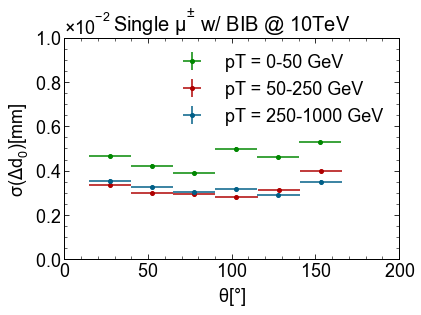

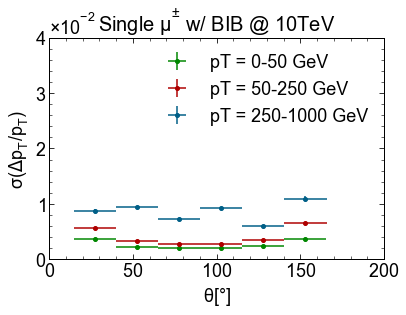

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


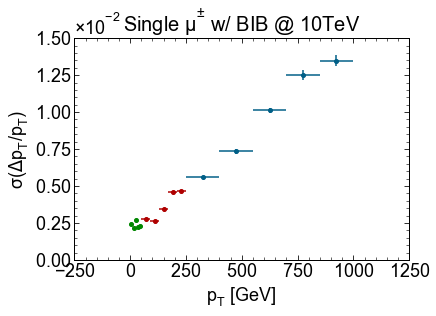

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


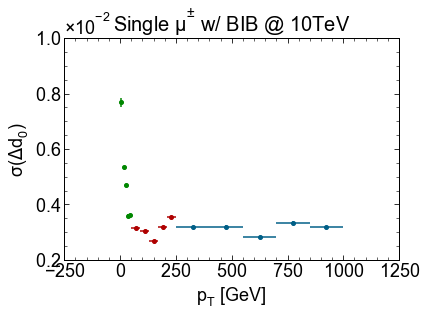

In [61]:
# theta_all = [LC_theta_match[np.ravel(LC_pt_match)<=50], LC_theta_match[(np.ravel(LC_pt_match)>50) & (np.ravel(LC_pt_match)<=250)], LC_theta_match[np.ravel(LC_pt_match)>250]]
# d0_all = [LC_d0[np.ravel(LC_pt_match)<=50], LC_d0[(np.ravel(LC_pt_match)>50) & (np.ravel(LC_pt_match)<=250)], LC_d0[np.ravel(LC_pt_match)>250]]
# pt_res_all = [LC_pt_res[np.ravel(LC_pt_match)<=50], LC_pt_res[(np.ravel(LC_pt_match)>50) & (np.ravel(LC_pt_match)<=250)], LC_pt_res[np.ravel(LC_pt_match)>250]]
# pt_match_all =  [LC_pt_match[np.ravel(LC_pt_match)<=50], LC_pt_match[(np.ravel(LC_pt_match)>50) & (np.ravel(LC_pt_match)<=250)], LC_pt_match[np.ravel(LC_pt_match)>250]]
theta_all = [bib_0_50_theta, bib_50_250_theta, bib_250_1000_theta]
d0_all = [bib_0_50['LC_d0'], bib_50_250['LC_d0'], bib_250_1000['LC_d0']]
pt_res_all = [bib_0_50['LC_pt_res'], bib_50_250['LC_pt_res'], bib_250_1000['LC_pt_res']]
pt_match_all = [bib_0_50['LC_pt_match'], bib_50_250['LC_pt_match'], bib_250_1000['LC_pt_match']]
#print(theta_all,d0_all)
theta_all_masked = []
d0_all_masked = []
pt_res_all_masked = []
pt_match_all_masked = []
for i in range(len(theta_all)):
    x = theta_all[i]
    y = d0_all[i]
    z = pt_res_all[i]
    w = pt_match_all[i]
    # Create a boolean mask for the condition
    theta_cut = (0 <= x) & (x < 180)
    pt_res_cut = np.abs(z) > 0
    # Apply the mask to filter the arrays
    mask = theta_cut & pt_res_cut
    x_masked = x[mask]
    y_masked = y[mask]
    z_masked = z[mask]
    w_masked = w[mask]
    theta_all_masked.append(x_masked)
    d0_all_masked.append(y_masked)
    pt_res_all_masked.append(z_masked)
    pt_match_all_masked.append(w_masked)
# theta_all = ak.concatenate([theta_0_50, theta_50_250, theta_match],axis = 0)
numpoints = 6
d0_ylim = (0,0.01)
pt_ylim = (0,0.04)
plotrms_multi(theta_all_masked,d0_all_masked, bins = numpoints, ylim = d0_ylim,labels = ['pT = 0-50 GeV', 'pT = 50-250 GeV', 'pT = 250-1000 GeV'], xlabel = r'$\theta[\degree]$', ylabel = r'$\sigma(\Delta d_0)$[mm] ', title = r'Single $\mu^{\pm}$ w/ BIB @ 10TeV')
plotrms_multi(theta_all_masked,pt_res_all_masked, bins = numpoints, ylim = pt_ylim, labels = ['pT = 0-50 GeV', 'pT = 50-250 GeV', 'pT = 250-1000 GeV'], xlabel = r'$\theta[\degree]$', ylabel = r'$\sigma(\Delta p_T/p_T)$ ', title = r'Single $\mu^{\pm}$ w/ BIB @ 10TeV')
plotrms_multi(pt_match_all_masked,pt_res_all_masked, bins = 5, labels = ['_','_','_'], xlabel = r'$p_T$ [GeV]', ylabel = r'$\sigma(\Delta p_T/p_T)$ ', title = r'Single $\mu^{\pm}$ w/ BIB @ 10TeV')
plotrms_multi(pt_match_all_masked,d0_all_masked, bins = 5, labels = ['_','_','_'], xlabel = r'$p_T$ [GeV]', ylabel = r'$\sigma(\Delta d_0)$ ', title = r'Single $\mu^{\pm}$ w/ BIB @ 10TeV')

Theta: 0.0 <= theta < 180.0
# of data points: 23969
Slice 0: 0 to 1000
Mean from Fit: -0.00036690327873816994
Sigma from Fit: 0.002987527656784745
------------------------------------


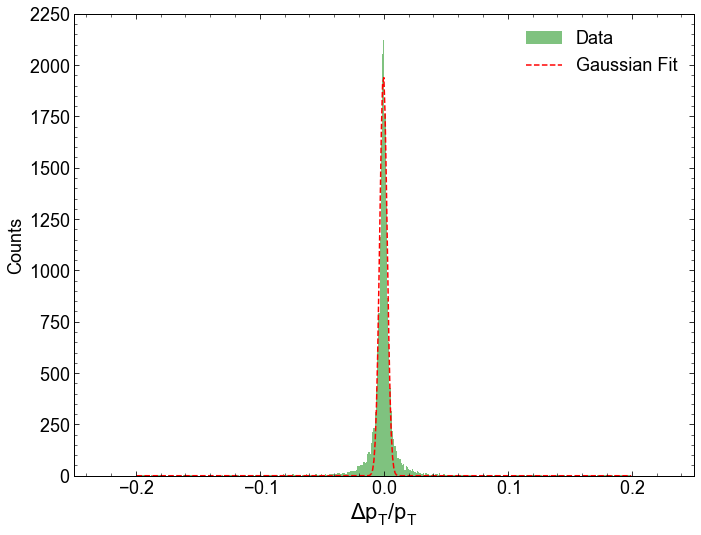

Slice 0: 0 to 1000
Mean from Fit: 0.00035898612329672005
Sigma from Fit: 0.003660407340997235
------------------------------------


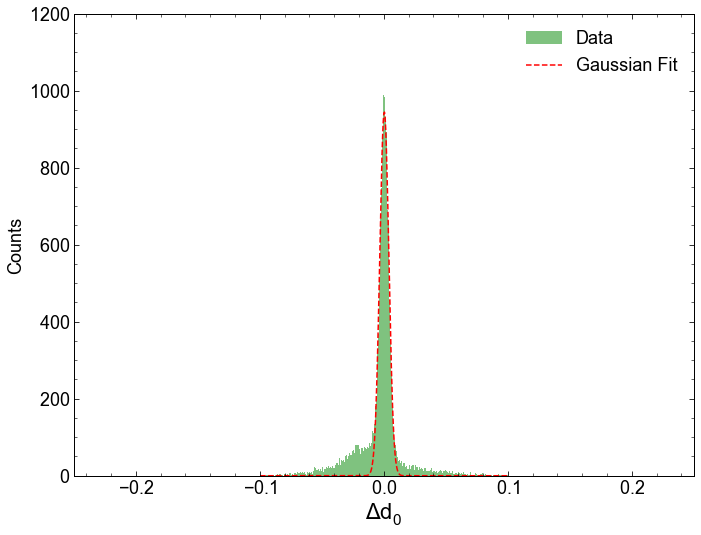

In [62]:
d0_bins = np.linspace(-0.1, 0.1, 400) # Seems to work fine using either linspace or just a number
pt_bins = np.linspace(-0.2,0.2, 400) # Unless there is a very hard cut on the LC_pt_res (< ~1), use linspace between -1,1, but even then not great in endcaps
eta_bins = np.linspace(-2.7, 2.7, 100)
chi2ndf_bins = np.linspace(0, 2, 100)
nhits_bins = np.linspace(0, 20, 100)
x_bins_50_250 = np.array([50,250])
x_bins_250_1000 = np.array([250,1000])
d0_title = r'$\Delta d_0$'
pt_title = r'$\Delta p_T$'
theta_bins = 1
which_pt = merged # 0-50, 50-250, 250-1000
which_theta = LC_theta_match # THIS HAS TO BE THE SAME AS which_pt!!!!
for i in range(theta_bins):
    print(r'Theta:', (180/theta_bins)*i, r'<= theta <', (180/theta_bins)*(i+1))
    theta_bin = ((180/theta_bins)*i <= which_theta) & (which_theta < (180/theta_bins)*(i+1)) & [np.abs(LC_pt_resolution[0]) < 1 for LC_pt_resolution in which_pt['LC_pt_res']]
    # print(which_pt['LC_pt_res'][theta_cut])
    count = 0
    for x in theta_bin:
        if x[0] == True:
            count +=1
    print("# of data points:", count)
    # First one has dpT, second one has dpT/pT
    #plotrms_slice(which_pt['LC_pt_match'][theta_bin], (which_pt['LC_pt_res']*which_pt['LC_pt_match'])[theta_bin], x_bins = x_bins_250_1000, bins=pt_bins, title=pt_title, rv = False, sigma5 = False)
    plotrms_slice(which_pt['LC_pt_match'][theta_bin], which_pt['LC_pt_res'][theta_bin], x_bins = [0,1000], bins=pt_bins, xlim = (-0.25,0.25), title=pt_title+r'/$p_T$', rv = False, sigma5 = False)
    plotrms_slice(which_pt['LC_pt_match'][theta_bin], which_pt['LC_d0'][theta_bin], x_bins = [0,1000], bins=d0_bins, xlim = (-0.25,0.25), title=d0_title, rv = False, sigma5 = False)
    # if i == 5:
    #     break
# sigma,mean = plotrms_slice(which_pt['LC_pt_match'], which_pt['LC_pt_res'], x_bins = x_bins_250_1000, bins=pT_bins, title=pt_title, rv = True, sigma5 = True)


### Comparing Bulk vs Tails 

In [63]:

# spread = 5*np.abs(sigma)
# print(np.mean(pt_res), np.std(pt_res))
# pt_bulk = np.array([-1*spread+mean <= x[0] < spread+mean for x in pt_res]) 
# pt_tails = np.array([x[0] < -1*spread+mean or x[0] >= spread+mean for x in pt_res])
# d0_bulk = np.array([-1*spread+mean <= x[0] < spread+mean for x in d0_res_match])
# d0_tails = np.array([x[0] < -1*spread+mean or x[0] >= spread+mean for x in d0_res_match])

In [64]:
# legends= ["Bulk", "Tail"]
# c = 0
# for x in [pt_match,eta_match,chi2/ndf, nhits]:
#     arrays = [x[pt_bulk], x[pt_tails]]
#     bins = np.linspace(np.min(x), np.max(x), 100)
#     if c == 0:
#         label = ';$p_{T}$'
#     elif c == 1:
#         label = r';$\eta$'
#     elif c == 2:
#         label = r';$\chi^2$/ndf'
#     elif c == 3:
#         label = r';$n_{\rm hits}$'
#     c += 1
#     compare1DHistograms(arrays, bins = bins, leg = legends, label = label)

### Plot 2D Hists showing resolution against $p_T$/$\eta$ and then the RMS of them against $\eta$

16559 16559


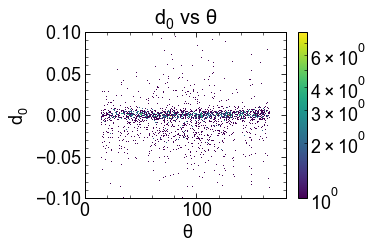

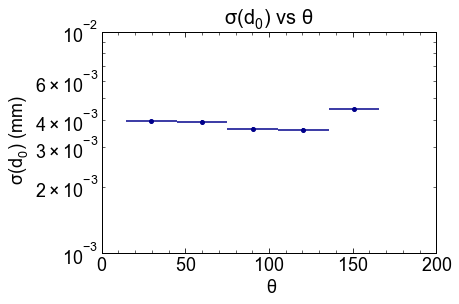

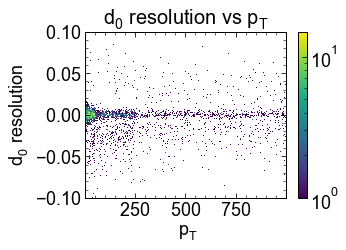

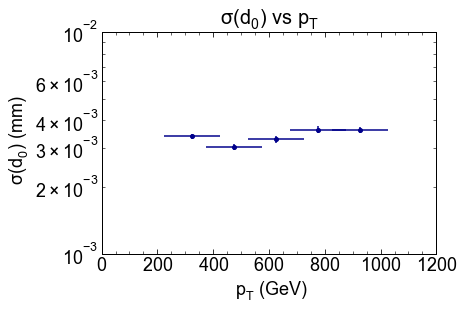

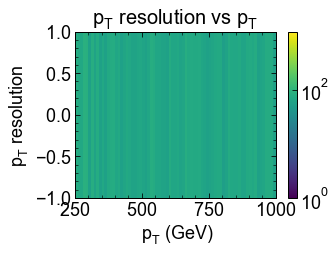

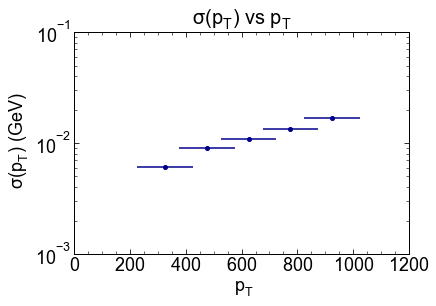

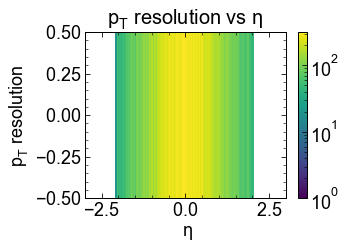

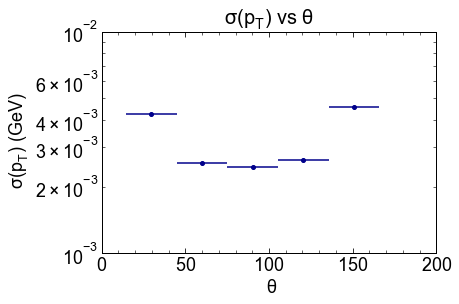

In [65]:
# # Histogram for mcp_eta
# plt.figure(figsize=(6, 3))

# plt.subplot(1, 2, 1)
# plt.hist((mcp_eta), bins=50, color='green')
# plt.xlabel('MCP $\\eta$')
# plt.ylabel('Count')
# plt.title('MCP $\\eta$ Distribution')

# # Histogram for mcp_phi
# plt.subplot(1, 2, 2)
# plt.hist((mcp_phi), bins=50, color='red')
# plt.xlabel('MCP $\\phi$')
# plt.ylabel('Count')
# plt.title('MCP $\\phi$ Distribution')

# # Adjust subplot spacing
# plt.tight_layout()

pt_xlim = [250,1000]
rms_bins = 5
print(len(theta_match),len(d0_res_match))
plot2DHistogram(theta_match, d0_res_match, bins=(300,1000), label=r"$d_0$ vs $\theta$; $\theta$;$d_0$", xlim = (0,180), ylim = (-0.1,0.1))
plotrms(theta_match, d0_res_match, bins=rms_bins, label=r"$\sigma(d_0)$ vs $\theta$; $\theta$; $\sigma(d_0)$ (mm)")
plot2DHistogram(pt_match, d0_res_match, bins=(300,1000), label=r"$d_0$ resolution vs $p_T$; $p_T$;$d_0$ resolution", ylim = (-0.1,0.1))#, xlim = (0,1000), ylim = (-0.1,0.1))
plotrms(pt_match, d0_res_match, bins=rms_bins, label=r"$\sigma(d_0)$ vs $p_T$; $p_T$ (GeV); $\sigma(d_0)$ (mm)", xlim = pt_xlim)
# plot2DHistogram(eta_match, z0_res_match, bins=(100,1000), label=r"$z_0$ resolution vs $\eta$; $\eta$;$z_0$ resolution", xlim = (-3,3), ylim = (-0.1,0.1))
# plotrms(eta_match, z0_res_match, bins=rms_bins, label=r"$\sigma(z_0)$ vs $\eta$; $\eta$; $\sigma(z_0)$")
# plot2DHistogram(pt_match, z0_res_match, bins=(100,1000), label=r"$z_0$ resolution vs $p_T$; $p_T$;$z_0$ resolution", xlim = pt_xlim, ylim = (-0.1,0.1))
# plotrms(pt_match, z0_res_match, bins=rms_bins, label=r"$\sigma(z_0)$ vs $p_T$; $p_T$; $\sigma(z_0)$", xlim = pt_xlim)
plot2DHistogram(pt_match, pt_res, bins=(100,15000), label=r"$p_T$ resolution vs $p_T$; $p_T$ (GeV);$p_T$ resolution", xlim = pt_xlim, ylim = (-1,1))
plotrms(pt_match, pt_res, bins=rms_bins, label=r"$\sigma(p_T)$ vs $p_T$; $p_T$; $\sigma(p_T)$ (GeV)", xlim = pt_xlim)
plot2DHistogram(eta_match, pt_res, bins=(100,15000), label=r"$p_T$ resolution vs $\eta$; $\eta$;$p_T$ resolution", xlim = (-3,3), ylim = (-0.5,0.5))
plotrms(theta_match, pt_res, bins=rms_bins, label=r"$\sigma(p_T)$ vs $\theta$; $\theta$; $\sigma(p_T)$ (GeV)")

### Residual Studies

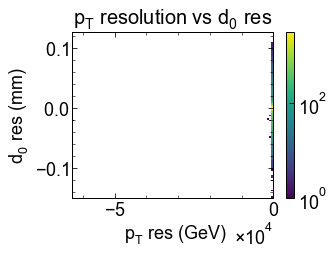

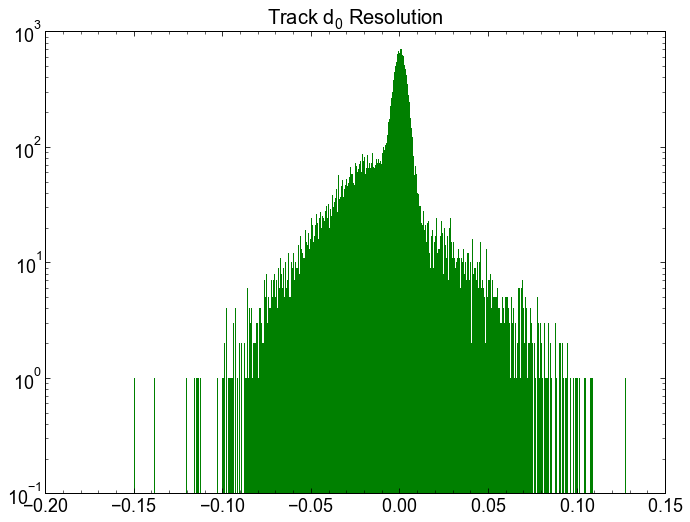

In [66]:
plot2DHistogram(pt_res, d0_res_match, bins=(100,100), label=r"$p_T$ resolution vs $d_0$ res; $p_T$ res (GeV);$d_0$ res (mm)")
plt.hist((np.ravel(d0_res_match)), bins=500, color='green')
plt.yscale('log')
#plt.xlim(-1,1)
#plt.ylim(0,200)
plt.title('Track $d_0$ Resolution')
plt.show()


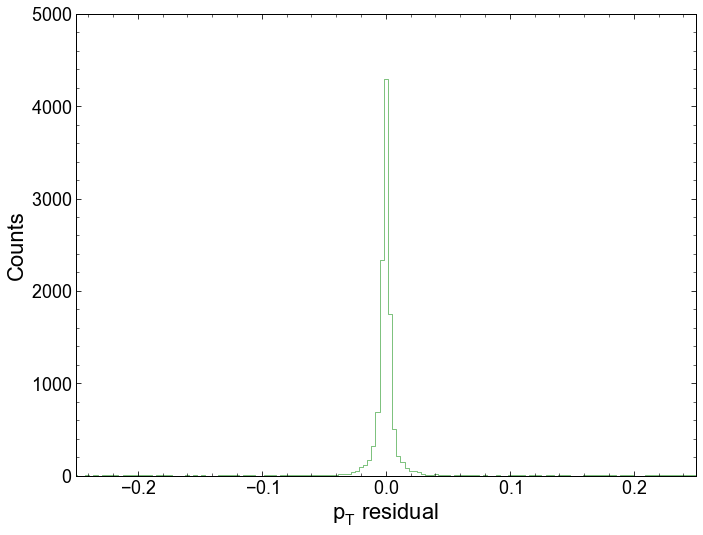

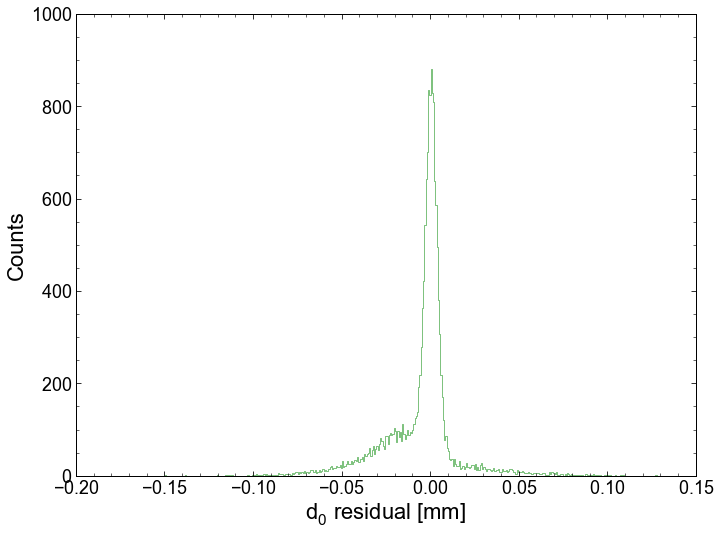

In [67]:
plt.figure()

plt.hist((np.ravel(pt_res[np.abs(pt_res) < 1])), bins=np.linspace(-0.5,0.5,300), histtype='step', label = "")
#plt.yscale('log')
plt.xlim(-0.25,0.25)
#plt.ylim(0,200)
#plt.title(r'$p_T$ Residual for pt_250_1000 data with no quality cut')
plt.xlabel(r'$p_T$ residual', fontsize = 22)
plt.ylabel('Counts', fontsize = 22)
#plt.yscale('log')
plt.show()

plt.hist((np.ravel(d0_res)), bins=400, histtype='step')
#plt.xlim(-1,1)
#plt.ylim(0,200)
#plt.title(r'$d_0$ Residual for pt_250_1000 data')
plt.xlabel(r'$d_0$ residual [mm]', fontsize = 22)
plt.ylabel('Counts', fontsize = 22)
#plt.yscale('log')
plt.show()


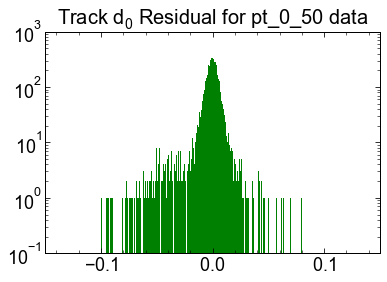

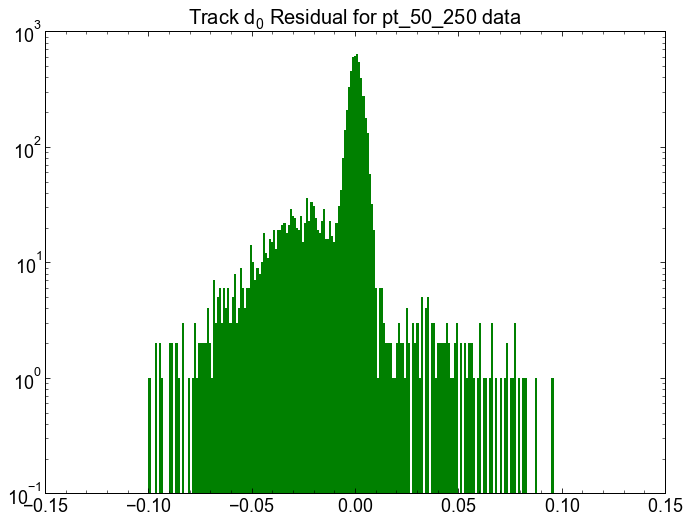

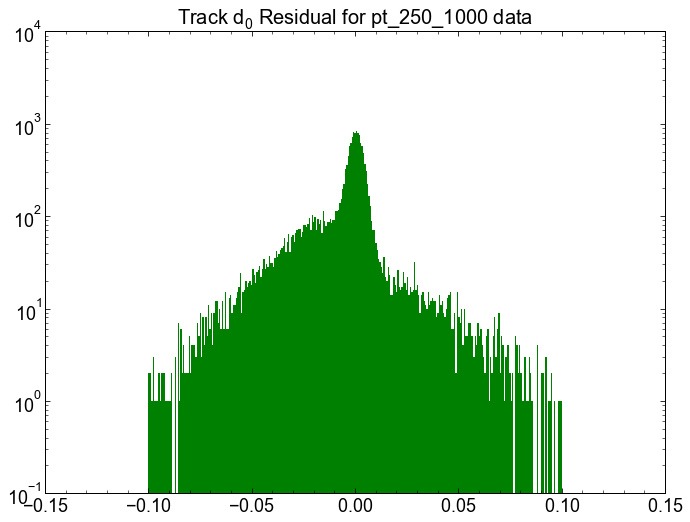

In [68]:
from importlib import reload
plt=reload(plt)
#plot2DHistogram(legacy['pt_match'], legacy['d0_res_match'],bins=(100,15000), label=r"$d_0$ Residual vs $d_0$; $d_0$ (GeV);$d_0$ Residual", xlim = [250,1000], ylim = (-2,2))
plt.figure(figsize=(6, 4))
d0_res_match_50_250 = pt_50_250['d0_res_match']

plt.hist((np.ravel(pt_0_50['d0_res_match'])), bins=np.linspace(-0.1,0.1,300), color='green')
plt.yscale('log')
#plt.xlim(-0.1,0.1)
#plt.ylim(0,200)
plt.title(r'Track $d_0$ Residual for pt_0_50 data')
plt.xlabel
plt.show()

plt.hist((np.ravel(d0_res_match_50_250)), bins=np.linspace(-0.1,0.1,200), color='green')
plt.yscale('log')
#plt.xlim(-0.1,0.1)
#plt.ylim(0,200)
plt.title(r'Track $d_0$ Residual for pt_50_250 data')
plt.show()

plt.hist((np.ravel(d0_res_match)), bins=np.linspace(-0.1,0.1,300), color='green')
plt.yscale('log')
#plt.xlim(-0.1,0.1)
#plt.ylim(0,200)
plt.title(r'Track $d_0$ Residual for pt_250_1000 data')
plt.show()

### Misc. Studies

<Figure size 432x288 with 0 Axes>

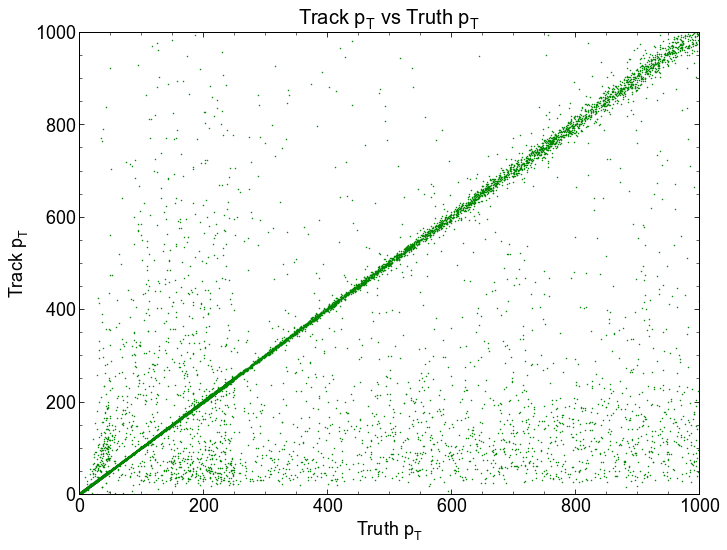

In [69]:
#from importlib import reload
#plt=reload(plt)
total_truth_pt = ak.concatenate([pt_0_50['mcp_mu_pt'], pt_50_250['mcp_mu_pt'], pt_250_1000['mcp_mu_pt']], axis=0)
total_track_pt = ak.concatenate([pt_0_50['pt_match'], pt_50_250['pt_match'], pt_250_1000['pt_match']], axis=0)  # this is also truth pt but only for muons that have a matched track associated with them
total_track_eta = ak.concatenate([pt_0_50['eta_match'], pt_50_250['eta_match'], pt_250_1000['eta_match']], axis=0)
total_truth_eta = ak.concatenate([pt_0_50['mcp_mu_eta'], pt_50_250['mcp_mu_eta'], pt_250_1000['mcp_mu_eta']], axis=0)
total_truth_phi = ak.concatenate([pt_0_50['mcp_mu_phi'], pt_50_250['mcp_mu_phi'], pt_250_1000['mcp_mu_phi']], axis=0)
total_track_phi = ak.concatenate([pt_0_50['phi_match'], pt_50_250['phi_match'], pt_250_1000['phi_match']], axis=0)
total_nhits = np.ravel(ak.concatenate([pt_0_50['nhits'], pt_50_250['nhits'], pt_250_1000['nhits']], axis=0))
total_pixel_nhits = np.ravel(ak.concatenate([pt_0_50['pixel_nhits'], pt_50_250['pixel_nhits'], pt_250_1000['pixel_nhits']], axis=0))
ttt = ak.concatenate([pt_0_50['track_pt'], pt_50_250['track_pt'], pt_250_1000['track_pt']], axis=0)  # just using for truth pt vs track pt below
total_pt_res = ak.concatenate([pt_0_50['track_pt'], pt_50_250['track_pt'], pt_250_1000['track_pt']], axis=0)

bib_truth_pt = ak.concatenate([bib_0_50['mcp_mu_pt'], bib_50_250['mcp_mu_pt'], bib_250_1000['mcp_mu_pt']], axis=0)
bib_track_pt = ak.concatenate([bib_0_50['LC_pt_match'], bib_50_250['LC_pt_match'], bib_250_1000['LC_pt_match']], axis=0)  # this is also truth pt but only for muons that have a matched track associated with them
bib_track_eta = ak.concatenate([bib_0_50['LC_eta_match'], bib_50_250['LC_eta_match'], bib_250_1000['LC_eta_match']], axis=0)
bib_truth_eta = ak.concatenate([bib_0_50['mcp_mu_eta'], bib_50_250['mcp_mu_eta'], bib_250_1000['mcp_mu_eta']], axis=0)
bib_truth_phi = ak.concatenate([bib_0_50['mcp_mu_phi'], bib_50_250['mcp_mu_phi'], bib_250_1000['mcp_mu_phi']], axis=0)
bib_track_phi = ak.concatenate([bib_0_50['LC_phi_match'], bib_50_250['LC_phi_match'], bib_250_1000['LC_phi_match']], axis=0)
bib_nhits = np.ravel(ak.concatenate([bib_0_50['LC_nhits'], bib_50_250['LC_nhits'], bib_250_1000['LC_nhits']], axis=0))
#bib_pixel_nhits = np.ravel(ak.concatenate([bib_0_50['pixel_nhits'], bib_50_250['pixel_nhits'], bib_250_1000['pixel_nhits']], axis=0))
bib_pt_res = ak.concatenate([bib_0_50['LC_pt_res'], bib_50_250['LC_pt_res'], bib_250_1000['LC_pt_res']], axis=0)


plt.figure(figsize=(6,4))
plt.subplots(1,1)
plt.scatter(np.ravel(total_track_pt), np.ravel(ttt), s=1)
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.title("Track $p_T$ vs Truth $p_T$")
plt.xlabel("Truth $p_T$")
plt.ylabel("Track $p_T$")
plt.show()

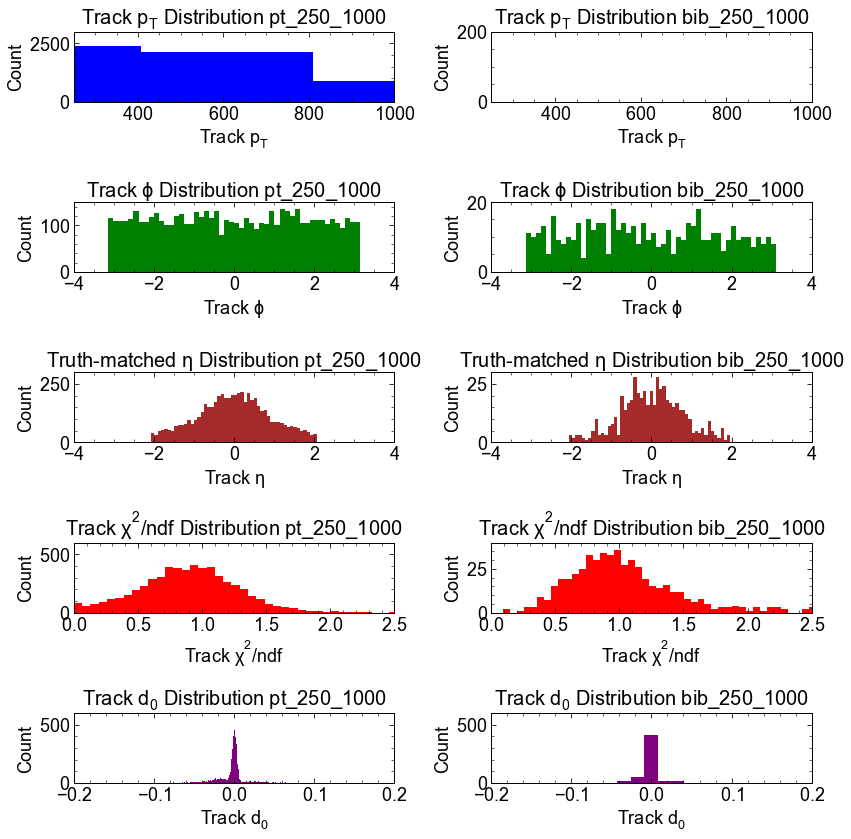

In [70]:
# Create histograms
plt.figure(figsize=(12, 12))

# Histogram for track pt
plt.subplot(5, 2, 1)
plt.hist(ak.flatten(pt_250_1000['track_pt']), bins=700, color='blue')
plt.xlim(250,1000)
plt.xlabel('Track $p_T$')
plt.ylabel('Count')
plt.title('Track $p_T$ Distribution pt_250_1000')

plt.subplot(5, 2, 2)
plt.hist(ak.flatten(bib_250_1000['track_pt']), bins=700, color='blue')
plt.xlim(250,1000)
plt.xlabel('Track $p_T$')
plt.ylabel('Count')
plt.title('Track $p_T$ Distribution bib_250_1000')

# Histogram for track phi
plt.subplot(5, 2, 3)
plt.hist(ak.flatten(pt_250_1000['phi_match']), bins=50, color='green')
plt.xlabel(r'Track $\phi$')
plt.ylabel('Count')
plt.title(r'Track $\phi$ Distribution pt_250_1000')

plt.subplot(5, 2, 4)
plt.hist(ak.flatten(bib_250_1000['phi_match']), bins=50, color='green')
plt.xlabel(r'Track $\phi$')
plt.ylabel('Count')
plt.title(r'Track $\phi$ Distribution bib_250_1000')

# Histogram for track eta
plt.subplot(5, 2, 5)
plt.hist(ak.flatten(pt_250_1000['eta_match']), bins=50, color='brown')
plt.xlabel(r'Track $\eta$')
plt.ylabel('Count')
plt.title(r'Truth-matched $\eta$ Distribution pt_250_1000')

plt.subplot(5, 2, 6)
plt.hist(ak.flatten(bib_250_1000['eta_match']), bins=50, color='brown')
plt.xlabel(r'Track $\eta$')
plt.ylabel('Count')
plt.title(r'Truth-matched $\eta$ Distribution bib_250_1000')

# Histogram for track ndf
plt.subplot(5, 2, 7)
plt.hist(ak.flatten(pt_250_1000['chi2'])/ak.flatten(pt_250_1000['ndf']), bins=50, color='red')
plt.xlim(0,2.5)
plt.xlabel(r'Track $\chi^2/ndf$')
plt.ylabel('Count')
plt.title(r'Track $\chi^2/ndf$ Distribution pt_250_1000')

plt.subplot(5, 2, 8)
plt.hist(ak.flatten(bib_250_1000['chi2'])/ak.flatten(bib_250_1000['ndf']), bins=50, color='red')
plt.xlim(0,2.5)
plt.xlabel(r'Track $\chi^2/ndf$')
plt.ylabel('Count')
plt.title(r'Track $\chi^2/ndf$ Distribution bib_250_1000')

# Histogram for track d0
plt.subplot(5, 2, 9)
plt.hist(ak.flatten(pt_250_1000['d0_res_match']), bins=300, color='purple')
plt.xlabel('Track $d_0$')
plt.ylabel('Count')
plt.title(r'Track $d_0$ Distribution pt_250_1000')
#plt.xlim(-0.1, 0.1)

plt.subplot(5, 2, 10)
plt.hist(ak.flatten(bib_250_1000['d0_res_match']), bins=300, color='purple')
plt.xlim(-0.2,0.2)
plt.xlabel('Track $d_0$')
plt.ylabel('Count')
plt.title('Track $d_0$ Distribution bib_250_1000')
#plt.xlim(-0.1, 0.1)

# Adjust subplot spacing
plt.tight_layout()

# Display the histograms
plt.show()


Text(0.5, 1.0, 'Track $p_T$ Distribution bib_250_1000')

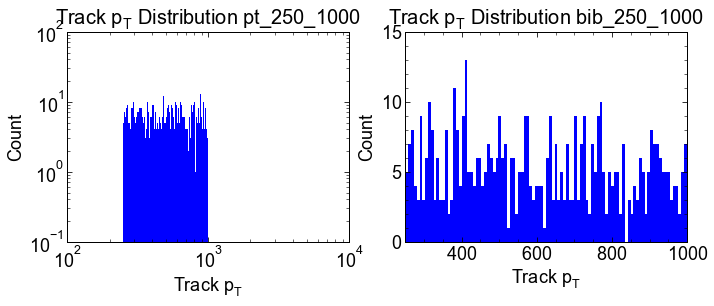

In [71]:
# Histogram for track pt
plt.subplot(2, 2, 1)
plt.hist(ak.flatten(pt_250_1000['pt_match']), bins=1000, color='blue')
#plt.xlim(250,1000)
plt.xlabel('Track $p_T$')
plt.ylabel('Count')
plt.title('Track $p_T$ Distribution pt_250_1000')
plt.yscale('log')
plt.xscale('log')


plt.subplot(2, 2, 2)
plt.hist(ak.flatten(bib_250_1000['pt_match']), bins=100, color='blue')
plt.xlim(250,1000)
plt.xlabel('Track $p_T$')
plt.ylabel('Count')
plt.title('Track $p_T$ Distribution bib_250_1000')
#plt.yscale('log')
#plt.xscale('log')


### Nhits Studies

<Figure size 432x288 with 0 Axes>

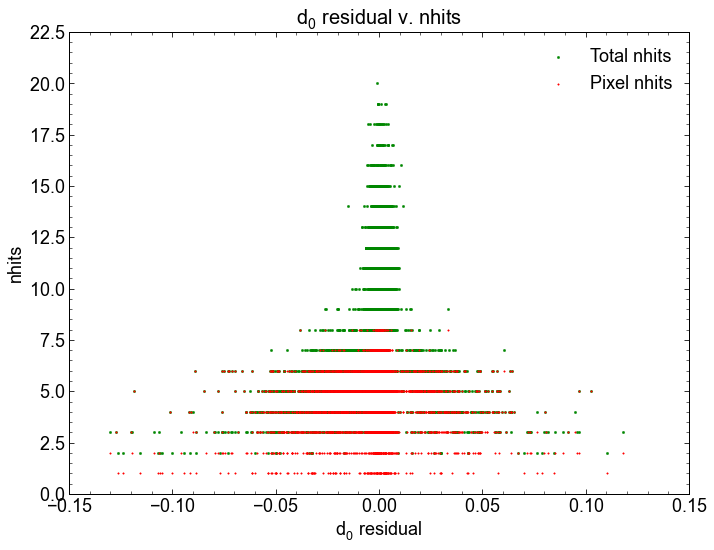

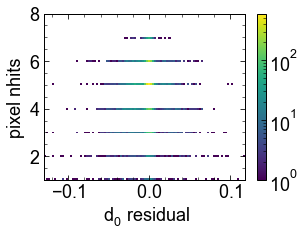

In [72]:
plt.figure(figsize=(6,4))
plt.subplots(1,1)
plt.scatter(pt_250_1000['d0_res_match'], pt_250_1000['nhits'],label = 'Total nhits', s=5)
plt.scatter(pt_250_1000['d0_res_match'], pt_250_1000['pixel_nhits'],label = 'Pixel nhits', c = 'red', s=2)
#plt.xlim(50,250)
#plt.ylim(50,250)
plt.xlabel("$d_0$ residual")
plt.ylabel("nhits")
plt.title("$d_0$ residual v. nhits")
plt.legend()
plt.show()

plot2DHistogram(pt_250_1000['d0_res_match'], pt_250_1000['pixel_nhits'], bins=(100,100), label=r"; $d_0$ residual;pixel nhits")


<Figure size 432x288 with 0 Axes>

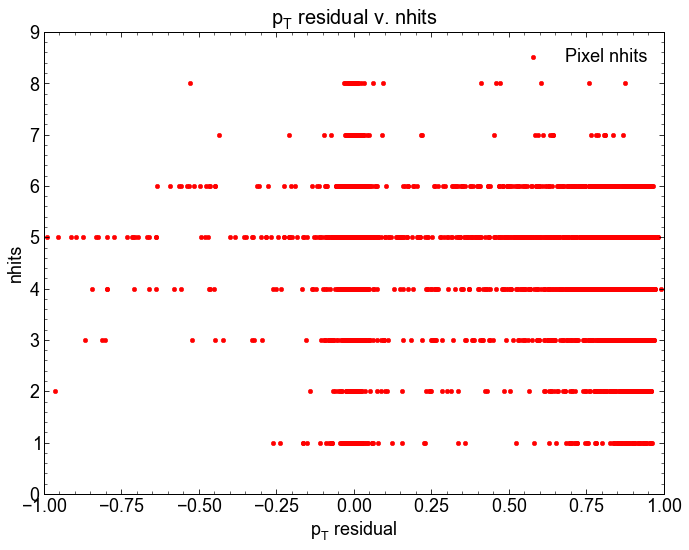

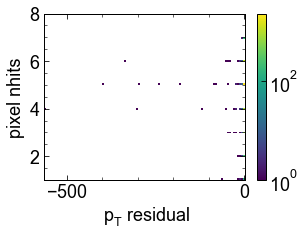

In [73]:
plt.figure(figsize=(6,4))
plt.subplots(1,1)
#plt.scatter(pt_250_1000['pt_res'], pt_250_1000['nhits'],label = 'Total nhits', s=50)
plt.scatter(pt_250_1000['pt_res'], pt_250_1000['pixel_nhits'],label = 'Pixel nhits', c = 'red', s=20)
plt.xlim(-1,1)
#plt.ylim(50,250)
plt.title("$p_T$ residual v. nhits")
plt.xlabel("$p_T$ residual")
plt.ylabel("nhits")
plt.legend()
plt.show()

plot2DHistogram(pt_250_1000['pt_res'][np.abs(np.ravel(pt_250_1000['pt_res'])) < 1000], pt_250_1000['pixel_nhits'][np.abs(np.ravel(pt_250_1000['pt_res'])) < 1000], bins=(100,100), label=r"; $p_T$ residual;pixel nhits")

<Figure size 432x288 with 0 Axes>

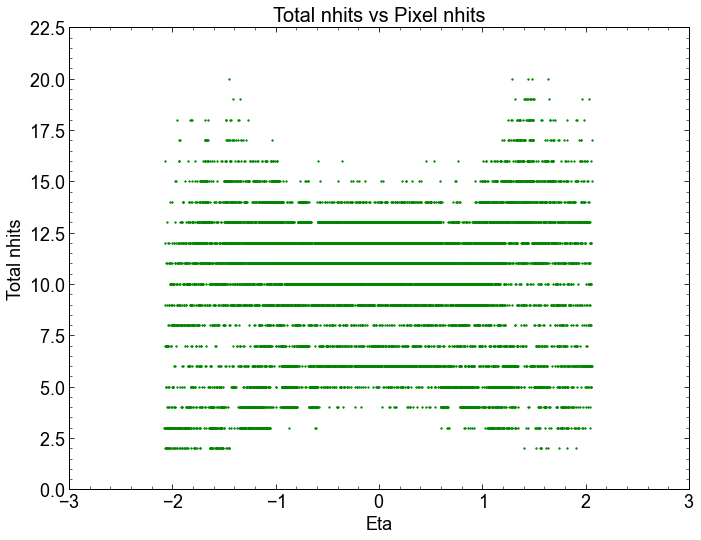

In [74]:
plt.figure(figsize=(6,4))
plt.subplots(1,1)
plt.scatter(np.ravel(total_track_eta), np.ravel(total_nhits), s=3)
#plt.xlim(0,1000)
#plt.ylim(0,1000)
plt.title("Total nhits vs Pixel nhits")
plt.ylabel("Total nhits")
plt.xlabel("Eta")
plt.show()

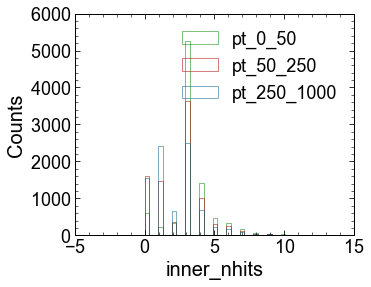

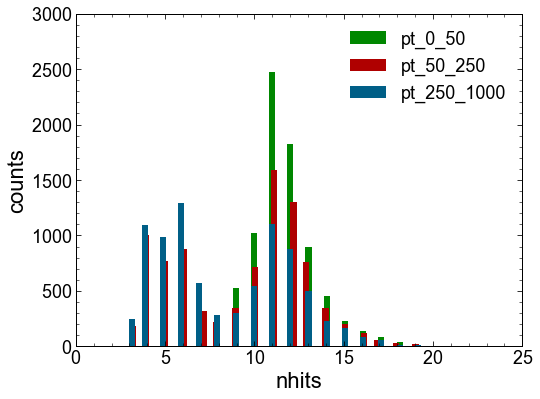

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


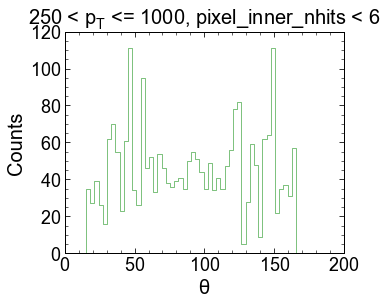

In [151]:
compare1DHistograms([np.ravel(merged['LC_inner_nhits'][np.ravel(merged['LC_pt_match']) <= 50]),
                    np.ravel(merged['LC_inner_nhits'][(np.ravel(merged['LC_pt_match']) > 50) & (np.ravel(merged['LC_pt_match']) <= 250)]),
                    np.ravel(merged['LC_inner_nhits'][np.ravel(merged['LC_pt_match'] > 250)])],
                   bins=40, label=";inner_nhits;Counts",
                   leg=["pt_0_50", "pt_50_250", "pt_250_1000"])
plt.figure(figsize=(8,6))
plt.hist(np.ravel(merged['LC_nhits'][np.ravel(merged['LC_pt_match']) <= 50]), bins = 50, label = "pt_0_50")
plt.hist(np.ravel(merged['LC_nhits'][(np.ravel(merged['LC_pt_match']) > 50) & (merged['LC_pt_match'] <= 250)]), bins = 50, label = "pt_50_250")
plt.hist(np.ravel(merged['LC_nhits'][np.ravel(merged['LC_pt_match'] > 250)]), bins = 50, label = "pt_250_1000")
#plt.hist(np.ravel(merged['fake_nhits']), bins = 50, label = "Fake")
plt.legend()
plt.xlabel("nhits", fontsize = 22)
plt.ylabel("counts", fontsize = 22)
plt.show()

compare1DHistograms([np.ravel(LC_theta_match[np.ravel(LC_pt_match > 250) & np.ravel(LC_nhits < 6)])],
                   bins=50, label=r"250 < $p_T$ <= 1000, pixel_inner_nhits < 6 ;$\theta$;Counts",)


#plot2DHistogram(total_track_eta, total_pixel_inner_nhits, bins=(100,100), label=r"pixel pixel_inner_nhits v. $\eta$; $\eta$;pixel_inner_nhits")



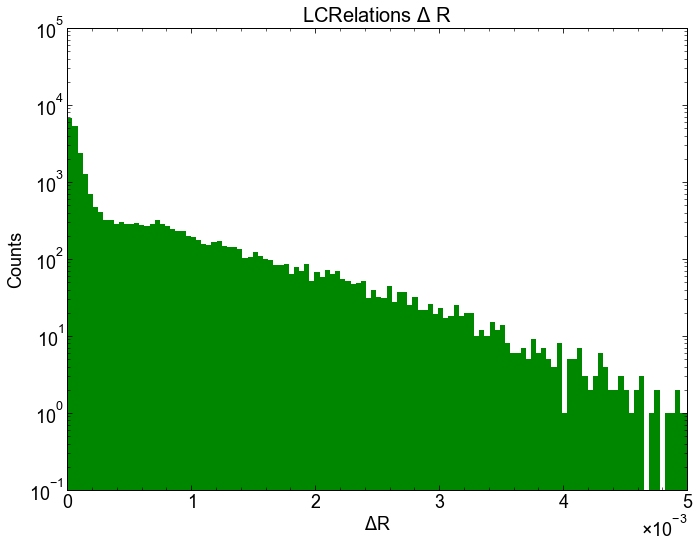

In [76]:
plt.hist(merged['LC_dr'], bins = 1000)
plt.xlim(0,0.005)
plt.xlabel(r"$\Delta$R")
plt.ylabel("Counts")
plt.title("LCRelations $\Delta$ R")
plt.yscale('log')

### Efficiency Studies

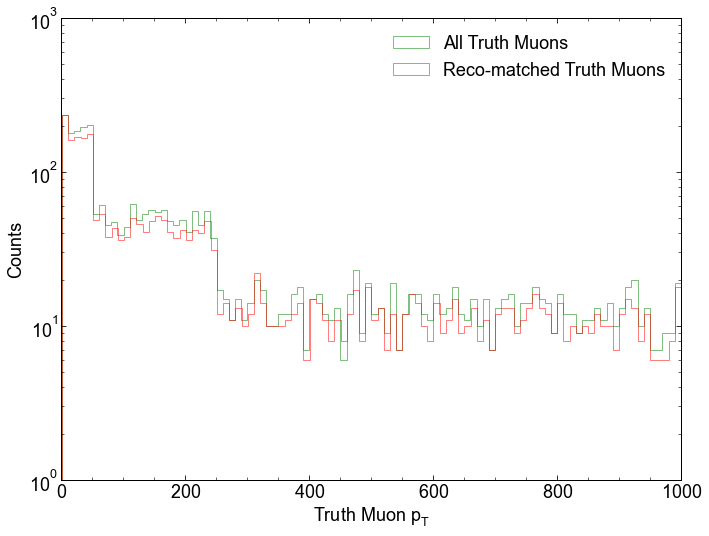

In [77]:
plt.figure()

plt.hist(np.ravel(bib_truth_pt), bins=100, color='green', label = 'All Truth Muons', histtype = 'step')
plt.hist((np.ravel(bib_track_pt)), bins=100, color='red', label = 'Reco-matched Truth Muons', alpha = 1, histtype = 'step')
plt.yscale('log')
plt.xlim(0,1000)
#plt.ylim(1,1000)
#plt.title(r'$p_T$ Residual for pt_250_1000 data with no quality cut')
plt.ylabel('Counts')
plt.xlabel(r'Truth Muon $p_T$')
plt.legend(loc = 'upper right')
plt.show()

2976
2614
1625
32


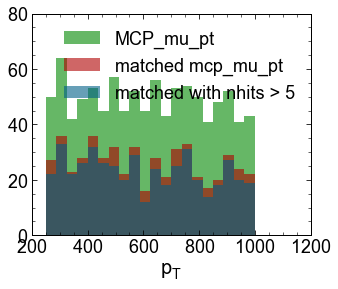

In [78]:
print(len(bib_truth_pt))#[np.ravel(bib_pt_res)<100000]))
print(len(bib_track_pt[np.ravel(bib_pt_res)<1]))
print(len(bib_track_pt[np.ravel(bib_pt_res)<0.001]))

print(len([True for x in np.ravel(bib_250_1000['nhits']) if x < 5]))
compare1DHistograms([bib_250_1000['mcp_mu_pt'], bib_250_1000['pt_match'],bib_250_1000['pt_match'][np.ravel(bib_250_1000['nhits'])>5]], bins = 20, label = ";$p_T$;", leg = ["MCP_mu_pt","matched mcp_mu_pt","matched with nhits > 5"])

In [79]:
print("% of bib_250_1000; 50_250; 0_50 w/ nhits")
for i in range(2,15):
    print("<", i, ":", len([True for x in np.ravel(bib_250_1000['nhits']) if x < i])*100/len(bib_250_1000['nhits']), ";", len([True for x in np.ravel(bib_50_250['nhits']) if x < i])*100/len(bib_50_250['nhits']), ";", len([True for x in np.ravel(bib_0_50['nhits']) if x < i])*100/len(bib_0_50['nhits']), "%")


% of bib_250_1000; 50_250; 0_50 w/ nhits
< 2 : 0.0 ; 0.0 ; 0.0 %
< 3 : 0.0 ; 0.0 ; 0.0 %
< 4 : 0.7604562737642585 ; 0.7067137809187279 ; 0.34305317324185247 %
< 5 : 6.083650190114068 ; 3.0035335689045937 ; 1.0291595197255574 %
< 6 : 11.977186311787072 ; 6.890459363957597 ; 1.8867924528301887 %
< 7 : 19.20152091254753 ; 10.070671378091873 ; 2.229845626072041 %
< 8 : 24.524714828897338 ; 12.897526501766784 ; 2.9159519725557463 %
< 9 : 27.566539923954373 ; 14.487632508833922 ; 6.861063464837049 %
< 10 : 33.07984790874525 ; 19.964664310954063 ; 12.864493996569468 %
< 11 : 40.874524714828894 ; 28.79858657243816 ; 24.528301886792452 %
< 12 : 67.30038022813689 ; 62.19081272084806 ; 58.490566037735846 %
< 13 : 88.02281368821293 ; 84.09893992932862 ; 81.81818181818181 %
< 14 : 94.48669201520913 ; 91.87279151943463 ; 91.59519725557462 %


In [80]:
print("% of noBIB_250_1000; 50_250; 0_50 w/ nhits")
for i in range(2,15):
    print("<", i, ":", len([True for x in np.ravel(pt_250_1000['nhits']) if x < i])*100/len(pt_250_1000['nhits']), ";", len([True for x in np.ravel(pt_50_250['nhits']) if x < i])*100/len(pt_50_250['nhits']), ";", len([True for x in np.ravel(pt_0_50['nhits']) if x < i])*100/len(pt_0_50['nhits']), "%")


% of noBIB_250_1000; 50_250; 0_50 w/ nhits
< 2 : 0.0 ; 0.0 ; 0.0 %
< 3 : 0.6620146716765074 ; 0.5825908156271419 ; 0.11796427367711493 %
< 4 : 4.061549472177491 ; 3.050034270047978 ; 0.6740815638692281 %
< 5 : 10.395419574163535 ; 8.156271418779987 ; 2.0222446916076846 %
< 6 : 17.58811952048667 ; 12.799862919808088 ; 3.016514998314796 %
< 7 : 27.088924673465737 ; 17.20356408498972 ; 3.8928210313447926 %
< 8 : 31.758811952048667 ; 19.002741603838246 ; 4.937647455342097 %
< 9 : 34.585793522991594 ; 21.213159698423578 ; 7.735085945399393 %
< 10 : 40.025049203793166 ; 26.49074708704592 ; 13.667003707448602 %
< 11 : 47.68294864913222 ; 35.31528444139822 ; 25.244354566902594 %
< 12 : 70.63875469672571 ; 63.69088416723783 ; 58.32490731378497 %
< 13 : 87.88692073716228 ; 83.68745716244003 ; 80.72126727334008 %
< 14 : 94.52495974235104 ; 92.7004797806717 ; 91.70879676440849 %


In [81]:
def plot_efficiency(track_data, truth_data, num_bins=50, min_value=None, max_value=None, nhits_min=0, xlabel=None, title=None, ylim=None, bib = False, nhits_label = False):# **kwargs):
    # num_bins = kwargs.get('num_bins', 50)
    # min_value = kwargs.get('min_value', min(flat_track_data))
    # max_value = kwargs.get('max_value', max(flat_track_data))
    # nhits_min = kwargs.get('nhits_min', 5)
    # xlabel = kwargs.get('xlabel', None)
    # title = kwargs.get('title', None)
    # ylim = kwargs.get('ylim', None)
    flat_track_data = np.ravel(track_data)
    flat_truth_data = np.ravel(truth_data)
    nhits = merged['LC_nhits'][::1]
    if bib:
        nhits = bib_nhits
    
    if isinstance(nhits_min, (int, float)):
        nhits_min = [nhits_min]  # Convert a single value to a list

    if min_value is None:
        min_value = np.min(flat_truth_data)

    if max_value is None:
        max_value = np.max(flat_truth_data)

    plt.figure(figsize=(8, 6))
    efficiency_bins = np.linspace(min_value, max_value, num_bins)

    alpha = 1.0
    size = 7
    for nhit in nhits_min:
        bin_width = efficiency_bins[1] - efficiency_bins[0]
        efficiencies = []
        errors = []
        bin_centers = []
        for i in range(len(efficiency_bins) - 1):
            bin_min = efficiency_bins[i]
            bin_max = efficiency_bins[i + 1]
            track_data_in_bin = flat_track_data[(flat_track_data >= bin_min) & (flat_track_data < bin_max) & (np.ravel(nhits) > nhit)]
            truth_data_in_bin = flat_truth_data[(flat_truth_data >= bin_min) & (flat_truth_data < bin_max)]
            if len(track_data_in_bin) != 0:
                efficiency = len(track_data_in_bin) / len(truth_data_in_bin)
                error = efficiency * np.sqrt((1 - efficiency) / len(track_data_in_bin))
            else:
                efficiency = 0
                error = 0
            efficiencies.append(efficiency)
            errors.append(error)
            bin_centers.append((bin_min + bin_max) / 2)
        bin_centers = (efficiency_bins[:-1] + efficiency_bins[1:]) / 2
        if nhits_label:
            label = f'Min nhits = {nhit}'
        else:
            label = None
        plt.errorbar(bin_centers, efficiencies, yerr=errors, xerr=bin_width/2, fmt='o', label=label, markersize=size, alpha = alpha)
        size -= 2
        alpha -= 0.2

    plt.xlim(min_value, max_value)
    plt.ylim(0,1)
    if ylim is not None:
        plt.ylim(ylim)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if bib:
        plt.ylabel('Reconstruction Efficiency (w/ BIB)')    
    else:
        plt.ylabel('Reconstruction Efficiency')
    if title is not None:
        plt.title(title)
    if nhits_label:
        plt.legend(loc = 'lower left')
    plt.show()

In [82]:
def compare_efficiency(track_data_list, truth_data_list, nhits_list, num_bins=20, min_value=None, max_value=None, nhits_min=0, xlabel=None, title=None, ylim=None, bib=False, nhits_label=False, labels = ""):
    if isinstance(nhits_min, (int, float)):
        nhits_min = [nhits_min]

    if min_value is None:
        min_value = np.min([np.min(np.ravel(truth_data)) for truth_data in truth_data_list])

    if max_value is None:
        max_value = np.max([np.max(np.ravel(truth_data)) for truth_data in truth_data_list])

    plt.figure(figsize=(8, 6))
    efficiency_bins = np.linspace(min_value, max_value, num_bins)

    alpha = 1.0
    size = 7
    for nhit in nhits_min:
        bin_width = efficiency_bins[1] - efficiency_bins[0]
        for i, (track_data, truth_data, nhits) in enumerate(zip(track_data_list, truth_data_list, nhits_list)):
            efficiencies = []
            errors = []
            bin_centers = []
            for j in range(len(efficiency_bins) - 1):
                bin_min = efficiency_bins[j]
                bin_max = efficiency_bins[j + 1]
                track_data_in_bin = np.ravel(track_data)[(np.ravel(track_data) >= bin_min) & (np.ravel(track_data) < bin_max) & (np.ravel(nhits) > nhit)]
                truth_data_in_bin = np.ravel(truth_data)[(np.ravel(truth_data) >= bin_min) & (np.ravel(truth_data) < bin_max)]
                if len(track_data_in_bin) != 0:
                    efficiency = len(track_data_in_bin) / len(truth_data_in_bin)
                    error = efficiency * np.sqrt((1 - efficiency) / len(track_data_in_bin))
                else:
                    efficiency = 0
                    error = 0
                efficiencies.append(efficiency)
                errors.append(error)
                bin_centers.append((bin_min + bin_max) / 2)
            bin_centers = (efficiency_bins[:-1] + efficiency_bins[1:]) / 2
            label = labels[i]
            if bib:
                b_lab = f'w/ BIB'
                label = label + b_lab
            if nhits_label:
                n_lab = f' min nhits = {nhit}'
                label = label + n_lab
            plt.errorbar(bin_centers, efficiencies, yerr=errors, xerr=bin_width/2, fmt='o', label=label, markersize=size, alpha=alpha)
        size -= 2
        alpha -= 0.2

    plt.xlim(min_value, max_value)
    plt.ylim(0, 1)
    if ylim is not None:
        plt.ylim(ylim)
    if xlabel is not None:
        plt.xlabel(xlabel)
    plt.legend(loc='lower left')
    plt.ylabel('Reconstruction Efficiency')
    if title is not None:
        plt.title(title)
    plt.show()


In [83]:
print(np.mean(bib_nhits))
print(np.mean(total_nhits))
print(np.mean(bib_250_1000['nhits']))
print(np.mean(pt_250_1000['nhits']))

total_truth_pt_b = total_truth_pt[np.abs((np.ravel(total_truth_eta))) <= 0.5]
total_track_pt_b = total_track_pt[np.abs((np.ravel(total_track_eta))) <= 0.5]
pt_b_nhits = total_nhits[np.abs((np.ravel(total_track_eta))) <= 0.5]

total_truth_pt_e = total_truth_pt[np.abs((np.ravel(total_truth_eta))) > 0.5]
total_track_pt_e = total_track_pt[np.abs((np.ravel(total_track_eta))) > 0.5]
pt_e_nhits = total_nhits[np.abs((np.ravel(total_track_eta))) > 0.5]

10.514537107880642
10.273633273806094
9.920152091254753
9.391662193594561


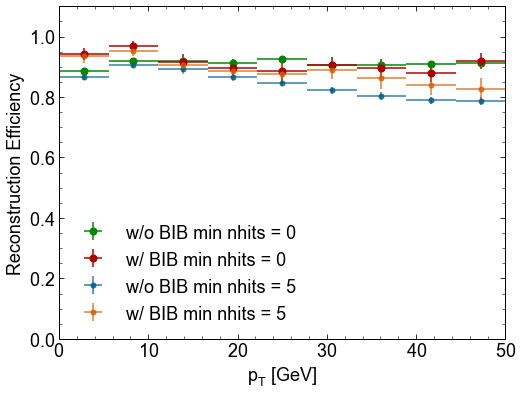

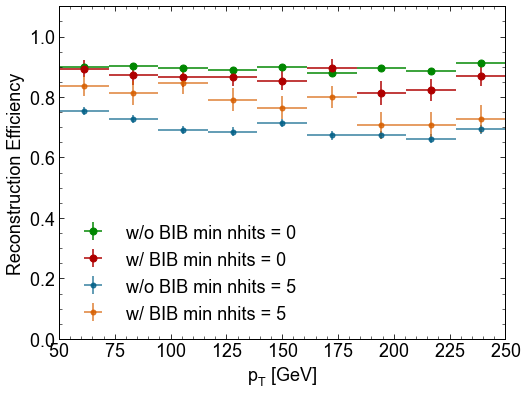

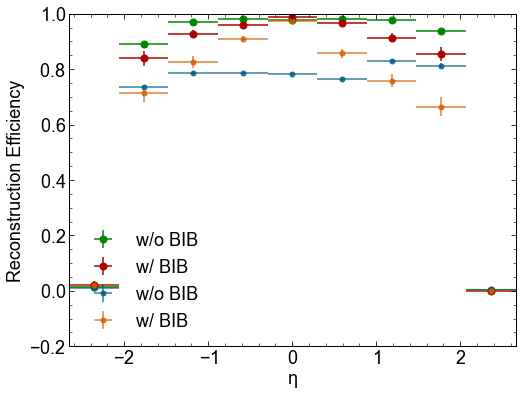

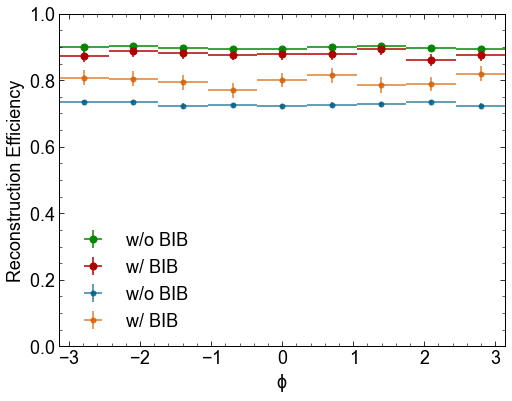

In [84]:
compare_efficiency([LC_pt_match,bib_track_pt], [mcp_mu_pt,bib_truth_pt], [LC_nhits, bib_nhits],num_bins=10, min_value=0, max_value=50, nhits_min=[0,5], xlabel=r'$p_T$ [GeV]', bib = False, nhits_label = True, ylim = (-0,1.1), labels = ["w/o BIB", "w/ BIB"])
compare_efficiency([LC_pt_match,bib_track_pt], [mcp_mu_pt,bib_truth_pt], [LC_nhits, bib_nhits],num_bins=10, min_value=50, max_value=250, nhits_min=[0,5], xlabel=r'$p_T$ [GeV]', bib = False, nhits_label = True, ylim = (-0,1.1), labels = ["w/o BIB", "w/ BIB"])
compare_efficiency([LC_eta_match,bib_track_eta], [mcp_mu_eta,bib_truth_eta], [LC_nhits, bib_nhits],num_bins=10, min_value=None, max_value=None, nhits_min=[0,5], xlabel=r'$\eta$', ylim = (-0.2,1), labels = ["w/o BIB", "w/ BIB"])#[r"|$\eta$| > 0.5", r"|$\eta$| < 0.5"])
compare_efficiency([LC_phi_match,bib_track_phi], [mcp_mu_phi,bib_truth_phi], [LC_nhits, bib_nhits],num_bins=10, min_value=None, max_value=None, nhits_min=[0,5], xlabel=r'$\phi$', ylim = (-0,1), labels = ["w/o BIB", "w/ BIB"])#[r"|$\eta$| > 0.5", r"|$\eta$| < 0.5"])
# plot_efficiency(bib_track_pt, bib_truth_pt, num_bins=10, min_value=None, max_value=None, nhits_min=[0,5,10], xlabel=r'$p_T$', bib = True, nhits_label=True, ylim = (0,1))
# plot_efficiency(LC_pt_match[::1], mcp_mu_pt[::1],num_bins=20, min_value=None, max_value=None, nhits_min=[0,5], xlabel=r'$p_T$ [GeV]', bib = False, nhits_label = False, ylim = (0,1), title = "")
# plot_efficiency(bib_track_eta[::1], bib_truth_eta[::1],num_bins=20, min_value=None, max_value=None, nhits_min=[0,5], xlabel=r'$\eta$', bib = True, nhits_label = False, ylim = (-0.2,1), title = "")
# plot_efficiency(bib_track_phi[::1], bib_truth_phi[::1],num_bins=20, min_value=None, max_value=None, nhits_min=[0,5], xlabel=r'$\phi$', bib = True, nhits_label = False, ylim = (-0.2,1), title = "")

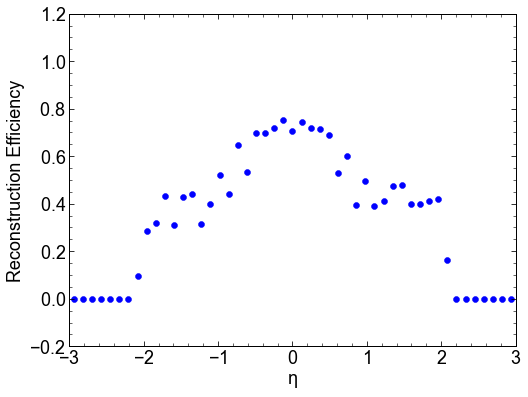

In [85]:
num_bins = 50
nhits_min = 5

min_eta = -3
max_eta = 3
efficiency_eta_bins = np.linspace(min_eta, max_eta, num_bins)

#write a test for the code in this cell?
# Calculate the efficiency for each pT bin.
efficiencies = []
truth_sum = 0
track_sum = 0
for i in range(len(efficiency_eta_bins) - 1):
    bin_min = efficiency_eta_bins[i]
    bin_max = efficiency_eta_bins[i + 1]
    #print("Eta range:", bin_min, bin_max)
    truth_generated_in_bin = np.ravel(total_truth_eta)[(np.ravel(total_truth_eta) >= bin_min) & (np.ravel(total_truth_eta) < bin_max)]
    #print((truth_generated_in_bin))
    truth_matched_in_bin = np.ravel(total_track_eta)[(np.ravel(total_track_eta) >= bin_min) & (np.ravel(total_track_eta) < bin_max) & (np.ravel(total_nhits) > nhits_min)] #& (np.ravel(total_pixel_nhits) > 3)]
    #print((truth_matched_in_bin))
    if len(truth_generated_in_bin) != 0:
        efficiency = len(truth_matched_in_bin) / len(truth_generated_in_bin)
    else:
        efficiency = 0
    #print(efficiency)
    efficiencies.append(efficiency)
    truth_sum += len(truth_generated_in_bin)
    track_sum += len(truth_matched_in_bin)
#print(truth_sum,track_sum)

# Convert the pT bin centers to a numpy array for plotting.
eta_bin_centers = (efficiency_eta_bins[:-1] + efficiency_eta_bins[1:]) / 2

# Create a scatter plot for the efficiency as a function of pT.
plt.figure(figsize=(8, 6))
plt.scatter(eta_bin_centers, efficiencies, marker='o', c='b')
plt.xlim(min_eta,max_eta)
plt.ylim(-0.2,1.2)
plt.xlabel(r'$\eta$')
plt.ylabel('Reconstruction Efficiency')
#plt.legend(loc='upper right')
plt.show()

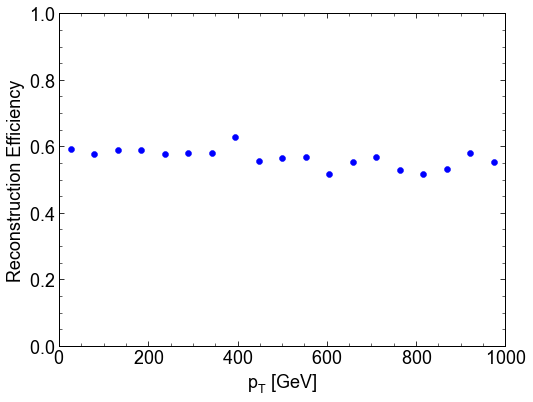

In [86]:
change_numbins = True
if change_numbins:
    num_bins = 20
    nhits_min = 0
min_pT = 0
max_pT = 1000
efficiency_pT_bins = np.linspace(min_pT, max_pT, num_bins)  # Define appropriate values for min_pT, max_pT, and num_bins.

efficiencies = []
truth_sum = 0
track_sum = 0
for i in range(len(efficiency_pT_bins) - 1):
    bin_min = efficiency_pT_bins[i]
    bin_max = efficiency_pT_bins[i + 1]
    truth_generated_in_bin = np.ravel(ak.concatenate([pt_0_50['mcp_mu_pt'], pt_50_250['mcp_mu_pt'], pt_250_1000['mcp_mu_pt']], axis=0))[(np.ravel(ak.concatenate([pt_0_50['mcp_mu_pt'], pt_50_250['mcp_mu_pt'], pt_250_1000['mcp_mu_pt']], axis=0)) >= bin_min) & (np.ravel(ak.concatenate([pt_0_50['mcp_mu_pt'], pt_50_250['mcp_mu_pt'], pt_250_1000['mcp_mu_pt']], axis=0)) < bin_max)]
    #print(len(truth_generated_in_bin))
    truth_matched_in_bin = np.ravel(ak.concatenate([pt_0_50['pt_match'], pt_50_250['pt_match'], pt_250_1000['pt_match']], axis=0))[(np.ravel(ak.concatenate([pt_0_50['pt_match'], pt_50_250['pt_match'], pt_250_1000['pt_match']], axis=0)) >= bin_min) & (np.ravel(ak.concatenate([pt_0_50['pt_match'], pt_50_250['pt_match'], pt_250_1000['pt_match']], axis=0)) < bin_max) & (np.ravel(ak.concatenate([pt_0_50['nhits'], pt_50_250['nhits'], pt_250_1000['nhits']], axis=0)) > nhits_min)]
    #print(len(truth_matched_in_bin))
    if len(truth_generated_in_bin) != 0:
        efficiency = len(truth_matched_in_bin) / len(truth_generated_in_bin)
    #print(efficiency)
    efficiencies.append(efficiency)
    truth_sum += len(truth_generated_in_bin)
    track_sum += len(truth_matched_in_bin)
#print(truth_sum,track_sum)

# Convert the pT bin centers to a numpy array for plotting.
pT_bin_centers = (efficiency_pT_bins[:-1] + efficiency_pT_bins[1:]) / 2

# Create a scatter plot for the efficiency as a function of pT.
plt.figure(figsize=(8, 6))
plt.scatter(pT_bin_centers, efficiencies, marker='o', c='b')
plt.xlim(min_pT,max_pT)
plt.ylim(0,1)
plt.xlabel(r'$p_T$ [GeV]')
plt.ylabel('Reconstruction Efficiency')
#plt.title('ak.concatenate([pt_0_50['pt_match'], pt_50_250['pt_match'], pt_250_1000['pt_match']], axis=0)')
#plt.legend(loc='upper right')
plt.show()

-3.141592653589793 -2.8108986900540254
[-3.07, -2.98, -3.06, -3.05, -2.86, ..., -3.13, -2.82, -3.03, -2.99, -2.93]
[-3.06, -2.86, -2.86, -3.02, -3.06, ..., -2.83, -2.82, -2.94, -2.88, -2.99]
0.5899814471243042
-2.8108986900540254 -2.4802047265182576
[-2.72, -2.79, -2.65, -2.56, -2.59, -2.64, ..., -2.6, -2.5, -2.52, -2.55, -2.55]
[-2.72, -2.79, -2.65, -2.79, -2.66, ..., -2.74, -2.71, -2.67, -2.52, -2.55]
0.5616966580976864
-2.4802047265182576 -2.14951076298249
[-2.47, -2.46, -2.39, -2.47, -2.43, ..., -2.37, -2.38, -2.34, -2.36, -2.38]
[-2.47, -2.46, -2.39, -2.43, -2.4, ..., -2.22, -2.21, -2.37, -2.34, -2.38]
0.5772151898734177
-2.14951076298249 -1.8188167994467224
[-2.08, -1.98, -1.96, -1.86, -2, -2.07, ..., -1.91, -1.97, -1.86, -2.11, -1.89]
[-2.08, -1.98, -2, -2.07, -2.12, -1.92, ..., -1.83, -1.84, -1.96, -1.91, -2.11]
0.5855018587360595
-1.8188167994467224 -1.4881228359109546
[-1.8, -1.64, -1.61, -1.72, -1.78, -1.66, ..., -1.49, -1.54, -1.7, -1.67, -1.51]
[-1.61, -1.72, -1.66, -1.6, 

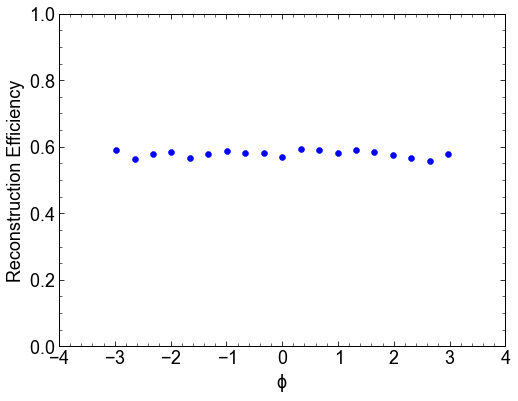

In [87]:
min_phi = -np.pi
max_phi = np.pi
efficiency_phi_bins = np.linspace(min_phi, max_phi, num_bins)

#write a test for the code in this cell?
# Calculate the efficiency for each pT bin.
efficiencies = []
truth_sum = 0
track_sum = 0
for i in range(len(efficiency_phi_bins) - 1):
    bin_min = efficiency_phi_bins[i]
    bin_max = efficiency_phi_bins[i + 1]
    print(bin_min, bin_max)
    truth_generated_in_bin = np.ravel(total_truth_phi)[(np.ravel(total_truth_phi) >= bin_min) & (np.ravel(total_truth_phi) < bin_max)]
    print((truth_generated_in_bin))
    truth_matched_in_bin = np.ravel(total_track_phi)[(np.ravel(total_track_phi) >= bin_min) & (np.ravel(total_track_phi) < bin_max) & (np.ravel(total_nhits) > nhits_min)]
    print((truth_matched_in_bin))
    if len(truth_generated_in_bin) != 0:
        efficiency = len(truth_matched_in_bin) / len(truth_generated_in_bin)
    print(efficiency)
    efficiencies.append(efficiency)
    truth_sum += len(truth_generated_in_bin)
    track_sum += len(truth_matched_in_bin)
print(truth_sum, track_sum)

# Convert the phi bin centers to a numpy array for plotting.
phi_bin_centers = (efficiency_phi_bins[:-1] + efficiency_phi_bins[1:]) / 2

# Create a scatter plot for the efficiency as a function of phi.
plt.figure(figsize=(8, 6))
plt.scatter(phi_bin_centers, efficiencies, marker='o', c='b')
#plt.xlim(-np, 4)
plt.ylim(0, 1)
plt.xlabel(r'$\phi$')
plt.ylabel('Reconstruction Efficiency')
#plt.legend(loc='upper right')
plt.show()

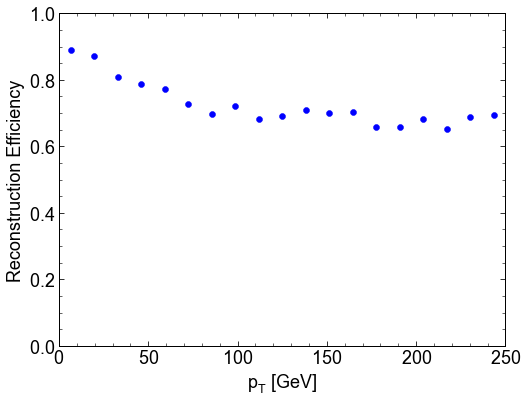

In [88]:
# Calculate the efficiency for each pT bin.
min_pT = 0
max_pT = 250
efficiency_pT_bins = np.linspace(min_pT, max_pT, num_bins)  # Define appropriate values for min_pT, max_pT, and num_bins.

efficiencies = []
truth_sum = 0
track_sum = 0
for i in range(len(efficiency_pT_bins) - 1):
    bin_min = efficiency_pT_bins[i]
    bin_max = efficiency_pT_bins[i + 1]
    truth_generated_in_bin = np.ravel(merged['mcp_mu_pt'])[(np.ravel(merged['mcp_mu_pt']) >= bin_min) & (np.ravel(merged['mcp_mu_pt']) < bin_max)]
    #print((truth_generated_in_bin))
    truth_matched_in_bin = np.ravel(merged['LC_pt_match'])[(np.ravel(merged['LC_pt_match']) >= bin_min) & (np.ravel(merged['LC_pt_match']) < bin_max) & (np.ravel(merged['LC_nhits']) > 5) & (np.ravel(merged['LC_pixel_nhits']) > 0)]
    #print(len(truth_matched_in_bin))
    if len(truth_generated_in_bin) != 0:
        efficiency = len(truth_matched_in_bin) / len(truth_generated_in_bin)
    #print(efficiency)
    efficiencies.append(efficiency)
    truth_sum += len(truth_generated_in_bin)
    track_sum += len(truth_matched_in_bin)
#print(truth_sum,track_sum)

# Convert the pT bin centers to a numpy array for plotting.
pT_bin_centers = (efficiency_pT_bins[:-1] + efficiency_pT_bins[1:]) / 2

# Create a scatter plot for the efficiency as a function of pT.
plt.figure(figsize=(8, 6))
plt.scatter(pT_bin_centers, efficiencies, marker='o', c='b')
plt.xlim(min_pT,max_pT)
plt.ylim(0,1)
plt.xlabel(r'$p_T$ [GeV]')
plt.ylabel('Reconstruction Efficiency')
#plt.title(r'$0 < p_T < 50$')
#plt.legend(loc='upper right')
plt.show()

### Fake Rate Studies

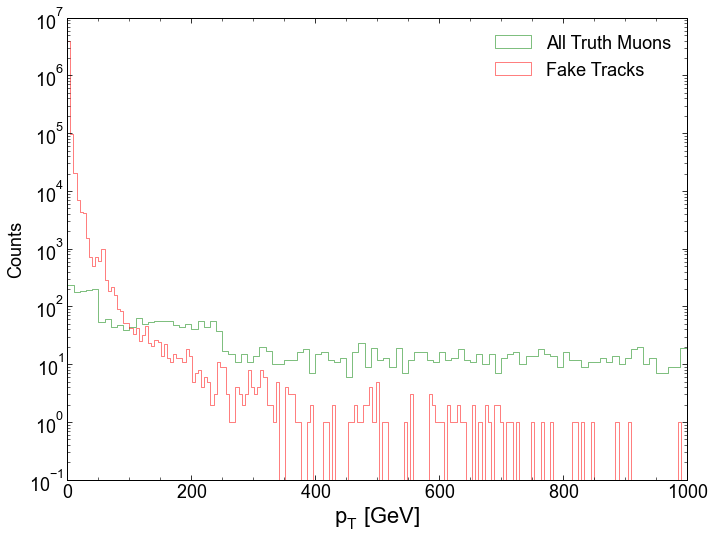

In [111]:
bib_fake_pt = np.concatenate([bib_0_50['fake_pt'], bib_50_250['fake_pt'], bib_250_1000['fake_pt']], axis = 0)
bib_fake_eta = np.concatenate([bib_0_50['fake_eta'], bib_50_250['fake_eta'], bib_250_1000['fake_eta']], axis = 0)
bib_fake_phi = np.concatenate([bib_0_50['fake_phi'], bib_50_250['fake_phi'], bib_250_1000['fake_phi']], axis = 0)
bib_fake_nhits = np.concatenate([bib_0_50['fake_nhits'], bib_50_250['fake_nhits'], bib_250_1000['fake_nhits']], axis = 0)

plt.figure()
plt.hist(np.ravel(bib_truth_pt), bins=100, color='green', label = 'All Truth Muons', histtype = 'step')
plt.hist((np.ravel(bib_fake_pt)), bins=np.linspace(0,1000,200), color='red', label = 'Fake Tracks', alpha = 1, histtype='step')
plt.yscale('log')
plt.xlim(0,1000)
#plt.ylim(1,1000)
#plt.title(r'$p_T$ Residual for pt_250_1000 data with no quality cut')
plt.ylabel('Counts')
plt.xlabel(r'$p_T$ [GeV]', fontsize = 22)
plt.legend(loc = 'upper right')
plt.show()

In [90]:
def plot_track_fraction(track_data, num_bins=20, min_value=None, max_value=None, xlabel=None, title=None, ylim=None):
    flat_track_data = np.ravel(track_data)
    print(flat_track_data)
   
    if min_value is None:
        min_value = np.min(flat_track_data)

    if max_value is None:
        max_value = np.max(flat_track_data)

    plt.figure(figsize=(8, 6))
    track_fraction_bins = np.linspace(min_value, max_value, num_bins)

    bin_width = track_fraction_bins[1] - track_fraction_bins[0]
    track_fractions = []
    errors = []
    for i in range(len(track_fraction_bins) - 1):
        bin_min = track_fraction_bins[i]
        bin_max = track_fraction_bins[i + 1]
        track_data_in_bin = flat_track_data[(flat_track_data >= bin_min) & (flat_track_data < bin_max)]
        #print(track_data_in_bin)
        #print(len(track_data_in_bin))
        num_events_in_bin = len(flat_track_data) # sum(1 for sublist in track_data if np.any((bin_min <= sublist) & (sublist < bin_max)))
        # print(num_events_in_bin)
        if len(track_data_in_bin) != 0:
            track_fraction = len(track_data_in_bin) / num_events_in_bin
            #error = track_fraction * np.sqrt((1 - track_fraction) / len(track_data_in_bin))
        else:
            track_fraction = 0
            #error = 0
        track_fractions.append(track_fraction)
        #errors.append(error)
    bin_centers = (track_fraction_bins[:-1] + track_fraction_bins[1:]) / 2
    # for i in range(len(track_fractions)-1):
    #     print(bin_centers[i], track_fractions[i])
    plt.bar(bin_centers, track_fractions, width = bin_width, align = 'center')

    plt.xlim(min_value, max_value)
    #plt.ylim(0, 1)
    if ylim is not None:
        plt.ylim(ylim)
    if xlabel is not None:
        plt.xlabel(xlabel)
    plt.ylabel('Track Fraction')
    if title is not None:
        plt.title(title)
    #plt.yscale('log')
    plt.show()



In [109]:
# Old, wrong
def plt_fake_rate(fake_data, num_bins=20, min_value=None, max_value=None, xlabel=None, title=None, ylim=None):
    flat_fake_data = np.ravel(fake_data)
    print(flat_fake_data)
   
    if min_value is None:
        min_value = np.min(flat_fake_data)

    if max_value is None:
        max_value = np.max(flat_fake_data)

    plt.figure(figsize=(8, 6))
    fake_rate_bins = np.linspace(min_value, max_value, num_bins)

    bin_width = fake_rate_bins[1] - fake_rate_bins[0]
    fake_rates = []
    errors = []
    for i in range(len(fake_rate_bins) - 1):
        bin_min = fake_rate_bins[i]
        bin_max = fake_rate_bins[i + 1]
        fake_data_in_bin = flat_fake_data[(flat_fake_data >= bin_min) & (flat_fake_data < bin_max)]
        #print(fake_data_in_bin)
        #print(len(fake_data_in_bin))
        num_events_in_bin = sum(1 for sublist in fake_data if np.any((bin_min <= sublist) & (sublist < bin_max)))
        # print(num_events_in_bin)
        if len(fake_data_in_bin) != 0:
            fake_rate = len(fake_data_in_bin) / num_events_in_bin
            #error = fake_rate * np.sqrt((1 - fake_rate) / len(fake_data_in_bin))
        else:
            fake_rate = 0
            #error = 0
        fake_rates.append(fake_rate)
        #errors.append(error)
    
    bin_centers = (fake_rate_bins[:-1] + fake_rate_bins[1:]) / 2
    plt.bar(bin_centers, fake_rates, width = bin_width)

    plt.xlim(min_value, max_value)
    #plt.ylim(0, 1)
    if ylim is not None:
        plt.ylim(ylim)
    if xlabel is not None:
        plt.xlabel(xlabel)
    plt.ylabel('Fake Rate')
    if title is not None:
        plt.title(title)
    #plt.yscale('log')
    plt.show()

# New, right
def plot_fake_rate(fake_data, num_bins=20, min_value=None, max_value=None, xlabel=None, title=None, ylim=None):
    flat_fake_data = np.ravel(fake_data)
    total_events = len(bib_truth_pt)

    if min_value is None:
        min_value = np.min(flat_fake_data)

    if max_value is None:
        max_value = np.max(flat_fake_data)

    plt.figure(figsize=(8, 6))
    fake_rate_bins = np.linspace(min_value, max_value, num_bins)
    weight = np.full(len(flat_fake_data), total_events)

    plt.hist(flat_fake_data, bins=fake_rate_bins, weights=weight, histtype='step')

    plt.xlim(min_value, max_value)
    if ylim is not None:
        plt.ylim(ylim)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize = 22)
    plt.ylabel('Fake Rate []', fontsize = 22)
    if title is not None:
        plt.title(title)
    plt.show()

17


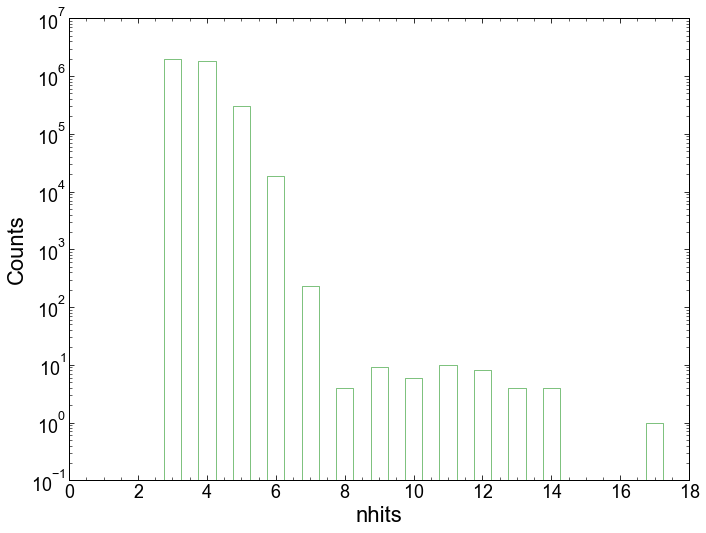

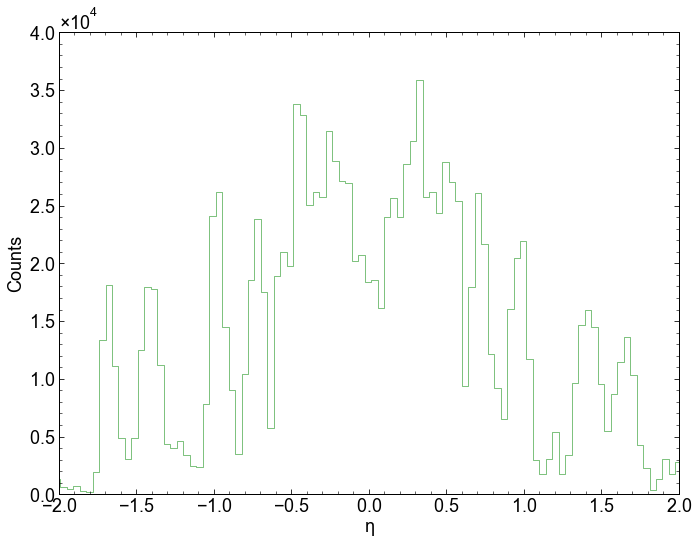

[-2.11, -2.09, -2.06, -2.04, -2.04, -2.04, ..., 1.93, 1.93, 2, 2.02, 2.02, 2.05]


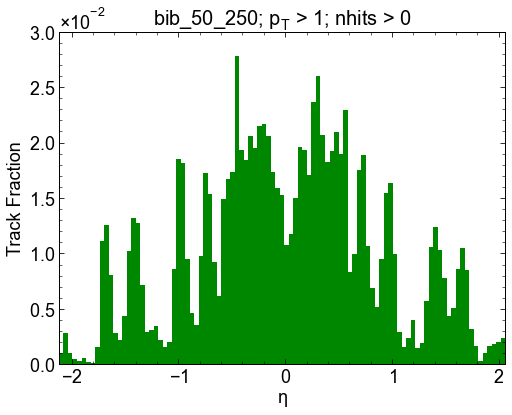

In [149]:
pt_cut = 1
nhits_cut = 0
print(np.max(bib_fake_nhits))
data_range = np.max(bib_fake_nhits) - np.min(bib_fake_nhits)
num_bins = int(data_range) + 1
bin_edges = np.arange(np.min(bib_fake_nhits) - 0.25, np.max(bib_fake_nhits) + 0.25 + 1, 0.5)

# Create the histogram with the calculated bin edges
plt.hist(np.ravel(bib_fake_nhits), bins=bin_edges, histtype='step')
plt.xlabel('nhits', fontsize = 22)
plt.ylabel('Counts', fontsize = 22)
plt.xlim(0,data_range+4)#np.max(np.ravel(bib_fake_nhits)))
plt.yscale('log')
plt.ylim(10**(-1),10**7)
plt.show()


plt.hist(np.ravel(bib_50_250['fake_eta'][((bib_50_250['fake_pt'])>0) & ((bib_50_250['fake_nhits']) > 0)]), bins = 100, histtype = 'step')
plt.xlabel("$\eta$")
plt.ylabel("Counts")
#plt.yscale("log")
plt.xlim(-2,2)
plt.show()

plot_track_fraction((bib_50_250['fake_eta'])[((bib_50_250['fake_pt'])>0) & ((bib_50_250['fake_nhits']) > 0)], num_bins = 100, min_value = None, max_value = None, xlabel = r"$\eta$", title = "bib_50_250; $p_T$ > " + str(pt_cut) + "; nhits > " + str(nhits_cut))

1370051
74742.43477640227
0.4273865908237021
[0.621, 0.974, 1.5, 1.92, 59.9, 0.463, ..., 0.376, 0.721, 1.4, 2.14, 0.894]


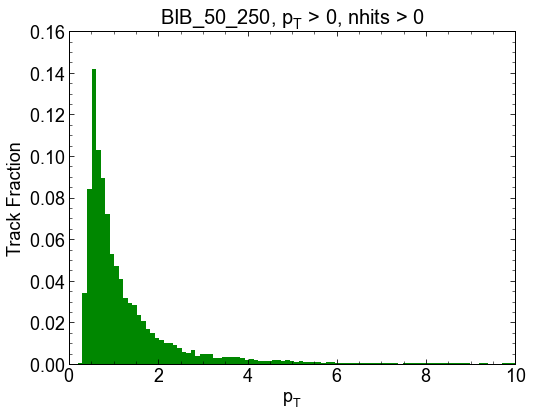

[4, 3, 3, 3, 3, 4, 4, 3, 4, 4, 4, 3, 3, ..., 4, 3, 3, 3, 3, 4, 3, 3, 6, 4, 3, 4]


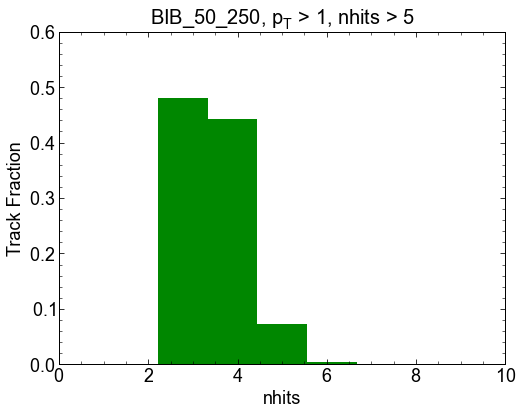

[-0.455, 1.4, 0.298, 0.211, 2.9, 0.155, ..., -0.00344, -0.301, 1.43, 3.08, 1.9]


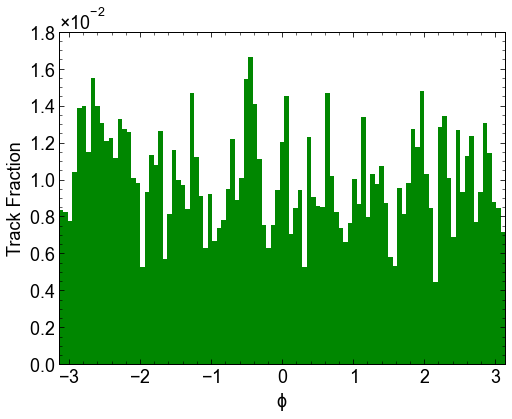

[-2.08, -2.07, -2.04, -2.01, -1.87, -1.77, ..., 1.9, 2, 2.02, 2.02, 2.04, 2.05]


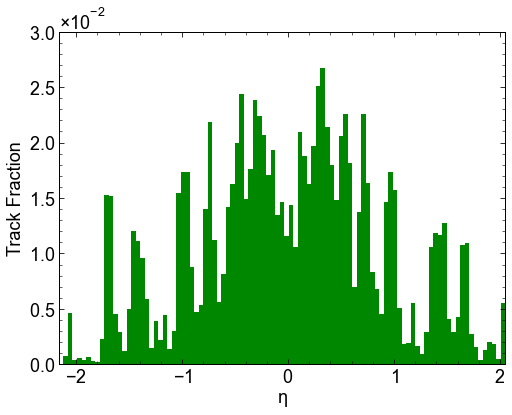

In [114]:
print(len(np.ravel(bib_50_250['fake_pt'])))
print(np.max(np.ravel(bib_50_250['fake_pt'])))
print(len(np.ravel(bib_fake_pt)[(np.ravel(bib_fake_pt)>1) & (np.ravel(bib_fake_nhits) > 0)])/len(np.ravel(bib_fake_pt)))
# Error encountered when fake rate is 100%
plot_track_fraction((bib_50_250['fake_pt'])[((bib_50_250['fake_pt'])>0) & ((bib_50_250['fake_nhits']) > 0)], num_bins = 100, min_value = 0, max_value = 10, xlabel = "$p_T$", title = "BIB_50_250, $p_T$ > 0, nhits > 0")
plot_track_fraction((bib_50_250['fake_nhits'])[((bib_50_250['fake_pt'])>0) & ((bib_50_250['fake_nhits']) > 0)], num_bins = 10, min_value = 0, max_value = 10, xlabel = "nhits", title = "BIB_50_250, $p_T$ > 1, nhits > 5")
plot_track_fraction(bib_fake_phi[((bib_fake_pt)>pt_cut)], num_bins = 100, min_value = None, max_value = None, xlabel = r"$\phi$")#, title = "BIB Fake Rate w/ $p_T$ > " + str(pt_cut) + "cut")
plot_track_fraction(bib_fake_eta[(bib_fake_pt>pt_cut)], num_bins = 100, min_value = None, max_value = None, xlabel = r"$\eta$")#, title = "BIB Fake Rate w/ $p_T$ > " + str(pt_cut) + "cut")

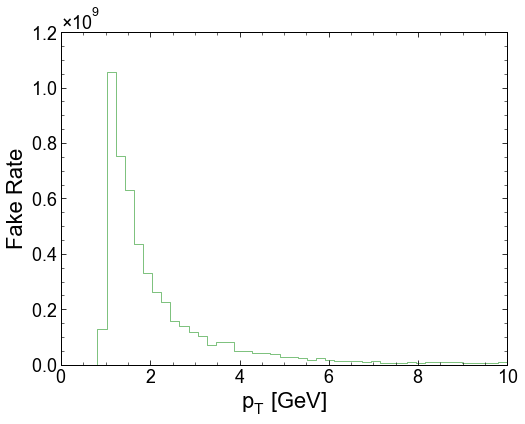

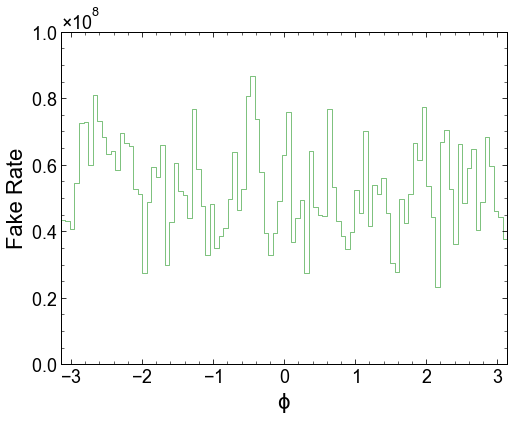

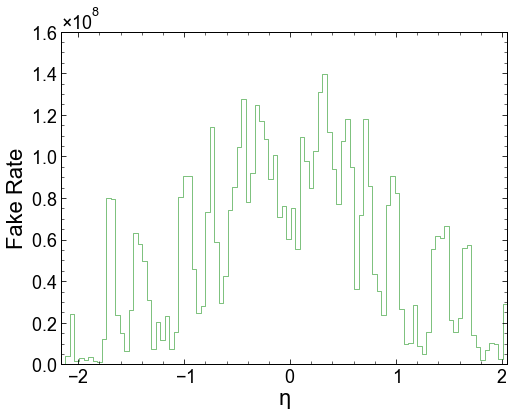

In [148]:
pt_cut = 1
nhits_cut = 0
# & ((bib_50_250['fake_nhits']) > nhits_cut)
plot_fake_rate((bib_fake_pt)[((bib_fake_pt)>pt_cut) & ((bib_fake_nhits)> nhits_cut)], num_bins = 50, min_value = 0, max_value = 10, xlabel = "$p_T$ [GeV]")#, title = "BIB Fake Rate w/ $p_T$ > " + str(pt_cut) + "cut") #> " + str(nhits_cut))
plot_fake_rate(bib_fake_phi[((bib_fake_pt)>pt_cut)], num_bins = 100, min_value = None, max_value = None, xlabel = r"$\phi$")#, title = "BIB Fake Rate w/ $p_T$ > " + str(pt_cut) + "cut")
plot_fake_rate(bib_fake_eta[(bib_fake_pt>pt_cut)], num_bins = 100, min_value = None, max_value = None, xlabel = r"$\eta$")#, title = "BIB Fake Rate w/ $p_T$ > " + str(pt_cut) + "cut")